# Process Player Data
We attempt to make sense of the player data by looking at certain distributions. But first we need to clean up the data.
* Get the age from birthday string
* Convert `string` to `int` type for some of the data columns
* Categorize positions types
* Extract injury types and categorize them into broader categories

In [15]:
from datetime import datetime

def extract_age(birthday_str):
    """
    Extracts age from a birthday string in format "Month Day, Year (Age)".
  
    Args:
      birthday_str (str): The birthday string containing month, day, year, and age.

    Returns:
      int: The extracted age as an integer.
    """
    # Split the string into components
    month, day, year, age = birthday_str.split()

    # Extract year (assuming age is in parentheses)
    age = int(age[1:-1])  # Remove closing parenthesis

    return age

In [16]:
def add_age_column(df):
    birthday_col = df['Birthday']
    ages = []
    for birthday_str in birthday_col:
        ages.append(extract_age(birthday_str))
    assert(len(ages) == len(birthday_col))
    df['Age'] = ages
    return df

In [17]:
def convert_to_int(df, column_name):
    """
    This function handles blank or '-' entries in an appearances column before converting it to integer.

    Args:
      df (pandas.DataFrame): The DataFrame containing the appearances column.
      column_name (str): The name of the appearances column.

    Returns:
      pandas.DataFrame: The DataFrame with the appearances column cleaned and converted to integer.
    """

    # Replace blank or '-' values with NaN (Not a Number)
    df[column_name] = df[column_name].replace(['', '-'], np.nan)

    # Convert the column to integer (fillna fills NaN with a specified value, 0 in this case)
    df[column_name] = df[column_name].fillna(0).astype(int)

    return df

In [18]:
def convert_days_to_int(df):
    """
    This function converts a column containing injury days in string format (e.g., "13 Days") to integer.

    Args:
      df (pandas.DataFrame): The DataFrame containing the "Total Days" column.
      column_name (str): The name of the "Total Days" column.

    Returns:
      pandas.DataFrame: The DataFrame with the "Total Days" column converted to integer.
    """

    # Extract the numerical part using regular expressions (import re if not already imported)
    import re
    pattern = r"(\d+)"  # Match one or more digits
    df["Total Days"] = df["Total Days"].str.extract(pattern, expand=False).astype(int)

    # Handle potential errors (e.g., 'nan' if no digits found)
    df["Total Days"] = pd.to_numeric(df["Total Days"], errors='coerce')  # Coerce errors to NaN

    return df

In [19]:
def convert_minutes_played(df):
    """
    Converts the minutes played column from string format (e.g., '4.386') to integer.

    Args:
      df (pandas.DataFrame): The DataFrame containing the minutes played column.
      column_name (str): The name of the minutes played column.

    Returns:
      pandas.DataFrame: The DataFrame with the minutes played column converted to integer.
    """
    # Remove the apostrophe and convert to float
    df["Minutes Played Total 23/24:"] = df["Minutes Played Total 23/24:"].astype(str).str.replace(".", "", regex=False)
    df["Minutes Played Total 23/24:"] = df["Minutes Played Total 23/24:"].astype(str).str.replace("'", "", regex=False)

    # Replace empty strings or '-' with NaN
    df["Minutes Played Total 23/24:"] = df["Minutes Played Total 23/24:"].replace(['', '-'], np.nan)
    df["Minutes Played Total 23/24:"] = df["Minutes Played Total 23/24:"].fillna(0).astype(int)

    # Multiply by 1000 to convert to integer minutes
    df["Minutes Played Total 23/24:"] = (df["Minutes Played Total 23/24:"]).astype(int)

    return df

In [20]:
def convert_height(df):
    """
    Converts the height column from string format (e.g., '1.70m') to integer.

    Args:
      df (pandas.DataFrame): The DataFrame containing the minutes played column.

    Returns:
      pandas.DataFrame: The DataFrame with the minutes played column converted to integer.
    """
    # Remove the apostrophe and convert to float
    df["Height"] = df["Height"].astype(str).str.replace("m", "", regex=False)
    df["Height"] = df["Height"].astype(str).str.replace(",", ".", regex=False)

    # Replace empty strings or '-' with NaN
    df["Height"] = df["Height"].replace(['', '-', 'UNK'], np.nan)
    df["Height"] = df["Height"].fillna(0).astype(float)

    # Multiply by 1000 to convert to integer minutes
    df["Height"] = (df["Height"]).astype(float)

    return df

In [21]:
import ast

def convert_injury_column(df):
    """
    Converts a string representation of a dictionary in a DataFrame column to an actual dictionary.

    Args:
      df (pandas.DataFrame): The DataFrame containing the injury column.
      column_name (str): The name of the injury column.

    Returns:
      pandas.DataFrame: The DataFrame with the converted injury column.
    """

    def convert_injury_string(injury_string):
        injury_string = injury_string.replace("'", '"')
        return ast.literal_eval(injury_string)

    df['Injuries'] = df['Injuries'].apply(convert_injury_string)
    return df

In [22]:
def extract_injury_types(df):
    """
    Extracts injury types from a dictionary column and creates a new column.

    Args:
      df (pandas.DataFrame): The DataFrame containing the injury column.
      injury_column (str): The name of the injury column.

    Returns:
      pandas.DataFrame: The DataFrame with an additional column 'Type of Injury' containing a list of injury types.
    """

    def extract_types(injury_dict):
        return list(injury_dict.keys())

    df['Type of Injury'] = df["Injuries"].apply(extract_types)
    return df

In [23]:
injury_categories = {
    'Ankle': ['Ankle', 'Ankle sprain', 'ankle sprain', 'Torn ankle ligaments', 'Ankle injury', 'Bruise on ankle', 'Inner ligament stretch of the knee', 'Ankle problems', 'Ankle ligament tear', 'Broken ankle', 'sprain', 'Injury to the ankle', 'Tendonitis', 'Broken fibula', 'Syndesmotic ligament tear', 'Ankle surgery'],
    'Back': ['Back problems', 'Lumbago', 'Back injury', 'Herniated disc', 'Lumbar vertebra problems', 'Inflammation in the spine'],
    'Calf/Shin': ['Calf injury', 'Shin injury', 'Calf problems', 'Calf strain'],
    'Foot': ['Foot bruise', 'Broken foot', 'Metatarsal fracture', 'Heel spur', 'Heel problems', 'Metatarsal bruise', 'Broken toe', 'Foot injury', 'Achilles tendon irritation', 'Tendon rupture', 'Achilles tendon rupture', 'Partial tear of the plantar fascia', 'Lower leg fracture', 'Arch problems', 'Fissure of the fibula', 'Achilles tendon contusion', 'Achilles tendon problems', 'Heel injury', 'Foot surgery', 'Longitudinal tendon tear', 'Toe injury', 'Achilles heel problems', 'Dead leg', 'Achilles tendon surgery', 'Leg injury'],
    'Groin': ['Groin problems', 'Groin surgery', 'Groin injury', 'Pubic bone irritation', 'Inflammation of the pubic bone', 'Inguinal hernia', 'Groin strain', 'Hip flexor problems', 'Adductor injury', 'Adductor pain', 'Outer ligament problems'],
    'Hamstring': ['Hamstring injury', 'Hamstring muscle injury', 'Hamstring strain', 'Torn muscle fiber in the adductor area'],
    'Head/Concussion': ['Head injury', 'Concussion', 'concussion', 'Broken nose bone', 'Nose injury', 'Nose surgery', 'Eyebow fracture', 'Facial injury', 'Broken cheekbone', 'Headache', 'Concussion', 'Broken jaw', 'Whiplash', 'minor knock', 'Neck injury', 'Knock'],  # Added some potential head injuries
    'Knee': ['Knee bruise', 'Bruised knee', 'Knee problems', 'Knee injury', 'Patellar tendon dislocation', 'Inner ligament stretch of the knee', 'Knee surgery', 'Knee collateral ligament tear', 'Knee medial ligament tear', 'Broken kneecap', 'Inner knee ligament tear', 'Patellar tendon rupture', 'Cruciate ligament surgery', 'Meniscus injury', 'Patellar tendinopathy syndrome', 'Patellar tendon problems', 'Cruciate ligament injury', 'Meniscus tear', 'Meniscus damage'],
    'Ligament': ['Inner ligament injury', 'Syndesmosis ligament tear', 'Collateral ligament injury', 'Ligament injury', 'Torn lateral ankle ligament', 'Knee collateral ligament tear', 'Inner knee ligament tear', 'Ligament stretching', 'Cruciate ligament tear', 'Torn lateral knee ligament', 'Internal ligament strain'],
    'Muscle': ['Muscle fatigue', 'Muscle injury', 'Muscle strain', 'Torn muscle fiber', 'Torn thigh muscle', 'Muscle contusion', 'Muscle fiber tear', 'Injury to abdominal muscles', 'muscle stiffness', 'Abdominal muscle strain', 'Torn muscle bundle', 'muscular problems', 'Overstretching', 'Muscle tear', 'strain'],
    'Thigh/Hip': ['Thigh problems', 'Hip injury', 'Hip problems', 'Hip bruise', 'Hip flexor problems', 'Strain in the thigh and gluteal muscles', 'Inflammation of the biceps tendon in the thigh', 'Pelvic contusion', 'Inflammation of pubic bone', 'Sciatica problems', 'Pubalgia', 'Right hip flexor problems'],
    'Hand/Shoulder/Elbow': ['Acromioclavicular joint dislocation', 'Elbow injury', 'Hand injury', 'Capsular injury', 'Metacarpal fracture', 'Scaphoid fracture', 'Broken finger', 'Broken collarbone', 'Forearm fracture', 'Broken hand', 'Broken arm', 'Finger injury', 'Shoulder injury'],
    'Other': ['Eye injury', 'inflammation', 'fatigue fracture', 'Fever', 'pneumonia', 'Fracture of the eye socket', 'Cancer', 'fracture', 'Corona virus', 'Bruised ribs', 'bruise', 'stomach problems', 'influenza', 'Cut', 'Intestinal virus', 'Appendectomy', 'surgery', 'unknown injury', 'malaria', 'Ill', 'cold', 'Tendon irritation', 'open wound', 'Stress reaction of the bone', 'Contracture', 'flu', 'infection', 'laceration wound', 'flesh wound', 'Stomach flu', 'depression', 'Capsule rupture', 'Toothache', 'Rest', 'Pneumothorax', 'Appendicitis', 'Tonsillitis', 'Bone bruise', 'Virus', 'angina', 'Fitness', 'Chest injury', 'Rib fracture', 'Abdominal problems', 'heart problems']
}

def categorize_injuries_df(df):
    """Categorizes injury types for each player in a DataFrame.

    Args:
      df (pandas.DataFrame): The DataFrame containing the injury column.
      injury_column (str): The name of the injury column.

    Returns:
      pandas.DataFrame: The DataFrame with an additional column 'Categorized Injuries'.
    """

    def categorize_injuries(injury_list):
        """Categorizes injury types into predefined groups.

        Args:
          injury_list (list): A list of injury types.

        Returns:
          list: A list of categorized injuries.
        """
        categorized_injuries = []
        for injury in injury_list:
            for category, injuries in injury_categories.items():
                if injury in injuries:
                    categorized_injuries.append(category)
                    break

        return categorized_injuries

    df['Categorized Injuries'] = df["Type of Injury"].apply(categorize_injuries)
    return df

In [24]:
position_categories = {
    'Goalkeeper': ['Goalkeeper'],
    'Defender': ['Centre-Back', 'Left-Back', 'Right-Back'],
    'Midfielder': ['Defensive Midfield', 'Central Midfield', 'Attacking Midfield', 'Left Midfield', 'Right Midfield'],
    'Forward': ['Left Winger', 'Right Winger', 'Centre-Forward', 'Second Striker']
}


def categorize_pos_df(df):
    """Categorizes position for each player in a DataFrame.

    Args:
      df (pandas.DataFrame): The DataFrame containing the injury column.

    Returns:
      pandas.DataFrame: The DataFrame with an additional column 'Categorized Position'.
    """

    def categorize_position(position):
        """Categorizes injury types into predefined groups.

        Args:
          injury_list (list): A list of injury types.

        Returns:
          list: A list of categorized injuries.
        """
        for category, positions in position_categories.items():
            if position in positions:
                return category

    df['Categorized Position'] = df["Position"].apply(categorize_position)
    return df

In [25]:
def get_injury_counts(df):
    def get_count(injuries):
        return len(injuries)
    df['Injury Count'] = df["Categorized Injuries"].apply(get_count)
    return df

In [26]:
# Average costs are obtained from research findings:
# https://www.howdengroup.com/sites/g/files/mwfley566/files/2022-09/Football-Injury-Index-September-22.pdf
pl_average_injury_cost = {
    'Goalkeeper': 0.14,
    'Defender': 0.17,
    'Midfielder': 0.18,
    'Forward': 0.20
}

la_liga_average_injury_cost = {
    'Goalkeeper': 0.06,
    'Defender': 0.11,
    'Midfielder': 0.16,
    'Forward': 0.23
}

bundesliga_average_injury_cost = {
    'Goalkeeper': 0.08,
    'Defender': 0.06,
    'Midfielder': 0.08,
    'Forward': 0.07
}

serie_a_average_injury_cost = {
    'Goalkeeper': 0.06,
    'Defender': 0.09,
    'Midfielder': 0.13,
    'Forward': 0.15
}

ligue_1_average_injury_cost = {
    'Goalkeeper': 0.10,
    'Defender': 0.10,
    'Midfielder': 0.11,
    'Forward': 0.15
}

def calculate_total_injury_cost(df, average_injury_cost):
    """Calculates total injury cost for each player based on position.

    Args:
      df (pandas.DataFrame): The DataFrame containing player data.
      average_injury_cost (dict): A dictionary mapping positions to average injury cost.

    Returns:
      pandas.DataFrame: The DataFrame with an additional column 'Total Injury Cost'.
    """

    # Create a mapping for efficient lookup
    position_cost_map = pd.Series(average_injury_cost)

    # Calculate total injury cost for each player based on position
    df['Average Injury Cost'] = df['Categorized Position'].map(position_cost_map) * df['Injury Count']

    return df

In [27]:
def standardise_clubs(df, club_mapping):
    # Replace club names using map
    df['Club'] = df['Club'].map(club_mapping).fillna(df['Club'])
    return df

In [28]:
import pandas as pd
import numpy as np

prem_player_data_df = pd.read_csv('/kaggle/input/collected-data/Player Data/prem_player_data.csv')
prem_player_data_df = add_age_column(prem_player_data_df)
prem_player_data_df = convert_to_int(prem_player_data_df, "Appearances")
prem_player_data_df = convert_to_int(prem_player_data_df, "Total Games Missed")
prem_player_data_df = convert_height(prem_player_data_df)
prem_player_data_df = convert_injury_column(prem_player_data_df)
prem_player_data_df = extract_injury_types(prem_player_data_df)
prem_player_data_df = categorize_injuries_df(prem_player_data_df)
prem_player_data_df = get_injury_counts(prem_player_data_df)
prem_player_data_df = categorize_pos_df(prem_player_data_df)
prem_player_data_df = calculate_total_injury_cost(prem_player_data_df, pl_average_injury_cost)
prem_player_data_df = convert_days_to_int(prem_player_data_df)
prem_player_data_df = convert_minutes_played(prem_player_data_df)
prem_club_mapping = {
    'Wolves U21': 'Wolves', 'Liverpool U21': 'Liverpool', 'West Ham U21': 'West Ham'
}
prem_player_data_df = standardise_clubs(prem_player_data_df, prem_club_mapping)

laliga_player_data_df = pd.read_csv('/kaggle/input/collected-data/Player Data/laliga_player_data.csv')
laliga_player_data_df = add_age_column(laliga_player_data_df)
laliga_player_data_df = convert_to_int(laliga_player_data_df, "Appearances")
laliga_player_data_df = convert_to_int(laliga_player_data_df, "Total Games Missed")
laliga_player_data_df = convert_height(laliga_player_data_df)
laliga_player_data_df = convert_injury_column(laliga_player_data_df)
laliga_player_data_df = extract_injury_types(laliga_player_data_df)
laliga_player_data_df = categorize_injuries_df(laliga_player_data_df)
laliga_player_data_df = get_injury_counts(laliga_player_data_df)
laliga_player_data_df = categorize_pos_df(laliga_player_data_df)
laliga_player_data_df = calculate_total_injury_cost(laliga_player_data_df, la_liga_average_injury_cost)
laliga_player_data_df = convert_days_to_int(laliga_player_data_df)
laliga_player_data_df = convert_minutes_played(laliga_player_data_df)
laliga_club_mapping = {
    'Real Sociedad B': 'Real Sociedad', 
    'Villarreal CF B': 'Villarreal', 
    'Celta Fortuna': 'Celta de Vigo', 
    'UD Almería B': 'UD Almería', 
    'Sevilla Atl.': 'Sevilla FC', 
    'Alavés B': 'Alavés', 
    'Las Palmas Atl.': 'UD Las Palmas', 
    'RM Castilla': 'Real Madrid', 
    'Getafe CF B': 'Getafe', 
    'Valencia B': 'Valencia', 
    'Bilbao Athletic': 'Athletic', 
    'Barça Atlètic': 'Barcelona'
}
laliga_player_data_df = standardise_clubs(laliga_player_data_df, laliga_club_mapping)

bundesliga_player_data_df = pd.read_csv('/kaggle/input/collected-data/Player Data/bundesliga_player_data.csv')
bundesliga_player_data_df = add_age_column(bundesliga_player_data_df)
bundesliga_player_data_df = convert_to_int(bundesliga_player_data_df, "Appearances")
bundesliga_player_data_df = convert_to_int(bundesliga_player_data_df, "Total Games Missed")
bundesliga_player_data_df = convert_height(bundesliga_player_data_df)
bundesliga_player_data_df = convert_injury_column(bundesliga_player_data_df)
bundesliga_player_data_df = extract_injury_types(bundesliga_player_data_df)
bundesliga_player_data_df = categorize_injuries_df(bundesliga_player_data_df)
bundesliga_player_data_df = get_injury_counts(bundesliga_player_data_df)
bundesliga_player_data_df = categorize_pos_df(bundesliga_player_data_df)
bundesliga_player_data_df = calculate_total_injury_cost(bundesliga_player_data_df, bundesliga_average_injury_cost)
bundesliga_player_data_df = convert_days_to_int(bundesliga_player_data_df)
bundesliga_player_data_df = convert_minutes_played(bundesliga_player_data_df)
bundesliga_club_mapping = {
    'Wolfsburg U19': 'VfL Wolfsburg', 
    'FSV Mainz 05 II': '1.FSV Mainz 05', 
    'RB Leipzig U19': 'RB Leipzig', 
    'B. Dortmund II': 'Bor. Dortmund', 
    'B. Dortmund U19': 'Bor. Dortmund', 
    'Stuttgart U19': 'VfB Stuttgart', 
    'FC Bayern II': 'Bayern Munich', 
    'SC Freiburg II': 'SC Freiburg', 
    'Leverkusen U19': 'B. Leverkusen', 
    "M'gladbach II": "Bor. M'gladbach"
}
bundesliga_player_data_df = standardise_clubs(bundesliga_player_data_df, bundesliga_club_mapping)

serie_a_player_data_df = pd.read_csv('/kaggle/input/collected-data/Player Data/serie_a_player_data.csv')
serie_a_player_data_df = add_age_column(serie_a_player_data_df)
serie_a_player_data_df = convert_to_int(serie_a_player_data_df, "Appearances")
serie_a_player_data_df = convert_to_int(serie_a_player_data_df, "Total Games Missed")
serie_a_player_data_df = convert_height(serie_a_player_data_df)
serie_a_player_data_df = convert_injury_column(serie_a_player_data_df)
serie_a_player_data_df = extract_injury_types(serie_a_player_data_df)
serie_a_player_data_df = categorize_injuries_df(serie_a_player_data_df)
serie_a_player_data_df = get_injury_counts(serie_a_player_data_df)
serie_a_player_data_df = categorize_pos_df(serie_a_player_data_df)
serie_a_player_data_df = calculate_total_injury_cost(serie_a_player_data_df, serie_a_average_injury_cost)
serie_a_player_data_df = convert_days_to_int(serie_a_player_data_df)
serie_a_player_data_df = convert_minutes_played(serie_a_player_data_df)

ligue_1_player_data_df = pd.read_csv('/kaggle/input/collected-data/Player Data/ligue_1_player_data.csv')
ligue_1_player_data_df = add_age_column(ligue_1_player_data_df)
ligue_1_player_data_df = convert_to_int(ligue_1_player_data_df, "Appearances")
ligue_1_player_data_df = convert_to_int(ligue_1_player_data_df, "Total Games Missed")
ligue_1_player_data_df = convert_height(ligue_1_player_data_df)
ligue_1_player_data_df = convert_injury_column(ligue_1_player_data_df)
ligue_1_player_data_df = extract_injury_types(ligue_1_player_data_df)
ligue_1_player_data_df = categorize_injuries_df(ligue_1_player_data_df)
ligue_1_player_data_df = get_injury_counts(ligue_1_player_data_df)
ligue_1_player_data_df = categorize_pos_df(ligue_1_player_data_df)
ligue_1_player_data_df = calculate_total_injury_cost(ligue_1_player_data_df, ligue_1_average_injury_cost)
ligue_1_player_data_df = convert_days_to_int(ligue_1_player_data_df)
ligue_1_player_data_df = convert_minutes_played(ligue_1_player_data_df)
ligue_1_club_mapping = {
    'Toulouse B': 'Toulouse', 
    'OGC Nice B': 'OGC Nice', 
    'Rennes B': 'Stade Rennais', 
    'Paris SG U19': 'Paris SG', 
    'RC Lens B': 'Lens', 
    'Stade Reims B': 'Stade Reims'
}
ligue_1_player_data_df = standardise_clubs(ligue_1_player_data_df, ligue_1_club_mapping)

# Create a list of DataFrames
all_dataframes = [prem_player_data_df, laliga_player_data_df, bundesliga_player_data_df, serie_a_player_data_df, ligue_1_player_data_df]

# Concatenate the DataFrames vertically
combined_df = pd.concat(all_dataframes, ignore_index=True)
combined_df.to_csv('combined_players_data.csv', index=False)  

The resulting dataframe is a sample of what we get from data processing and cleaning

In [29]:
combined_df.head()

Name           Birthday  Height          League    Club  \
0        Bernd Leno   Mar 4, 1992 (32)    1.90  Premier League  Fulham   
1       Marek Rodák  Dec 13, 1996 (27)    1.94  Premier League  Fulham   
2      Steven Benda   Oct 1, 1998 (25)    1.92  Premier League  Fulham   
3  Tosin Adarabioyo  Sep 24, 1997 (26)    1.96  Premier League  Fulham   
4         Issa Diop   Jan 9, 1997 (27)    1.94  Premier League  Fulham   

      Position  Appearances  \
0   Goalkeeper           41   
1   Goalkeeper            5   
2   Goalkeeper            3   
3  Centre-Back           25   
4  Centre-Back           25   

                                            Injuries  Total Days  \
0  {'Nose surgery': {'Days': '16 days', 'Games mi...          16   
1                                                 {}           0   
2                                                 {}           0   
3  {'Knock': {'Days': '12 days', 'Games missed': ...          99   
4  {'Calf problems': {'Days': '35 days', 'Games m...         112   

   Total Games Missed  Minutes Played Total 23/24:  Age  \
0                   3                         3690   32   
1                   0                          450   27   
2                   0                          270   25   
3                  12                         1995   26   
4                  16                         1949   27   

                                   Type of Injury  \
0                                  [Nose surgery]   
1                                              []   
2                                              []   
3                          [Knock, Groin surgery]   
4  [Calf problems, Hamstring injury, Foot injury]   

           Categorized Injuries  Injury Count Categorized Position  \
0             [Head/Concussion]             1           Goalkeeper   
1                            []             0           Goalkeeper   
2                            []             0           Goalkeeper   
3      [Head/Concussion, Groin]             2             Defender   
4  [Calf/Shin, Hamstring, Foot]             3             Defender   

   Average Injury Cost  
0                 0.14  
1                 0.00  
2                 0.00  
3                 0.34  
4                 0.51

# Get Basic Distributions

## Age Distribution Across Top 5 Leagues

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

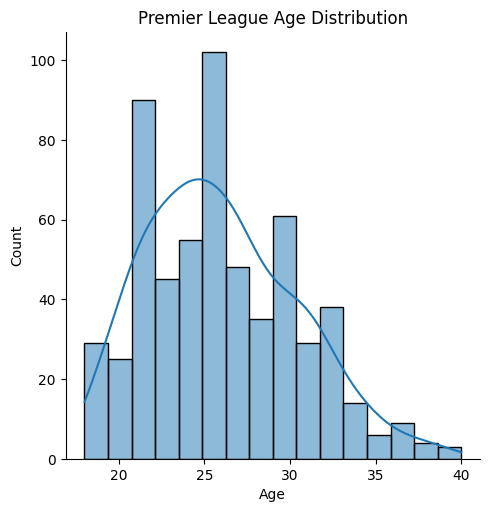

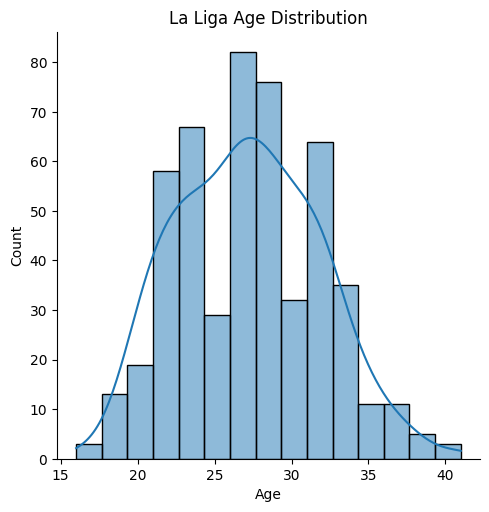

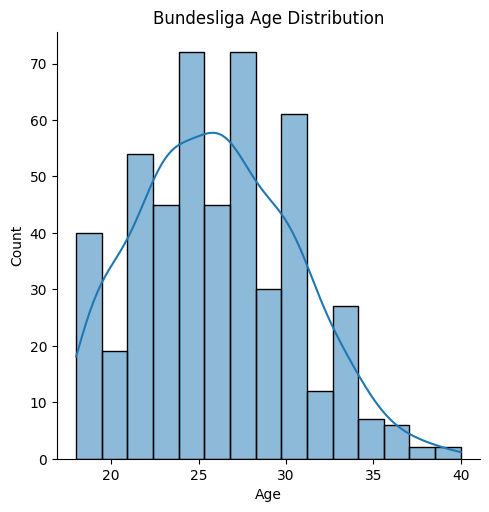

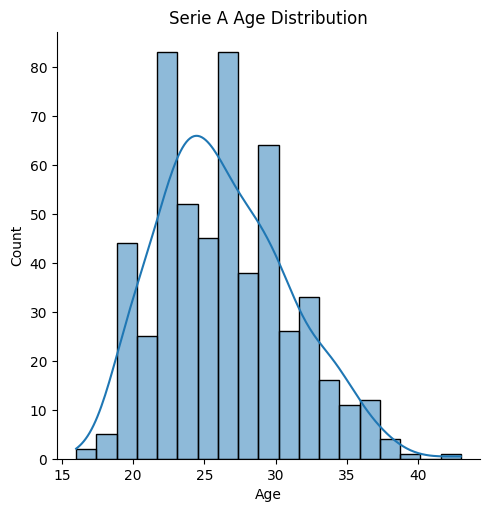

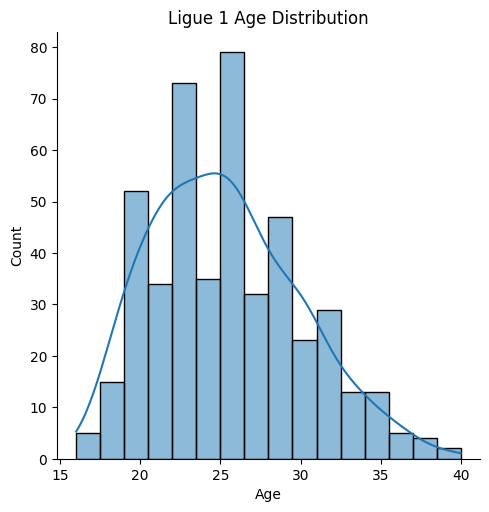

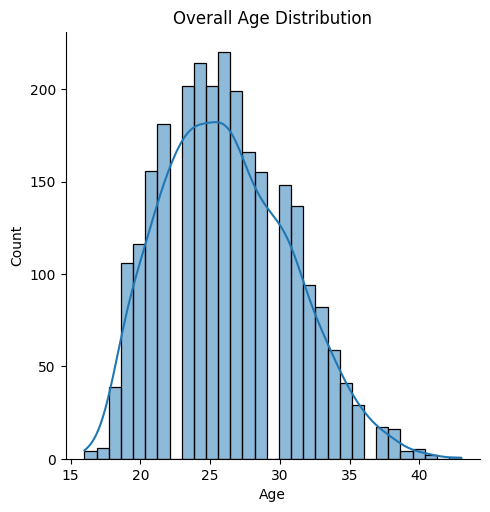

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.displot(data=prem_player_data_df, x="Age", kde=True).set(title='Premier League Age Distribution')
sns.displot(data=laliga_player_data_df, x="Age", kde=True).set(title='La Liga Age Distribution')
sns.displot(data=bundesliga_player_data_df, x="Age", kde=True).set(title='Bundesliga Age Distribution')
sns.displot(data=serie_a_player_data_df, x="Age", kde=True).set(title='Serie A Age Distribution')
sns.displot(data=ligue_1_player_data_df, x="Age", kde=True).set(title='Ligue 1 Age Distribution')
sns.displot(data=combined_df, x="Age", kde=True).set(title='Overall Age Distribution')

## Position Distribution Across Top 5 Leagues

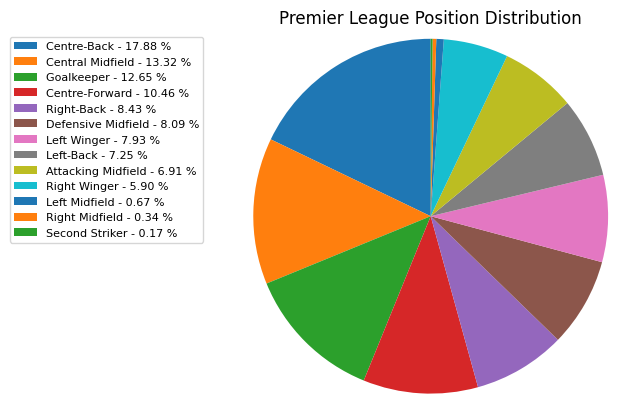

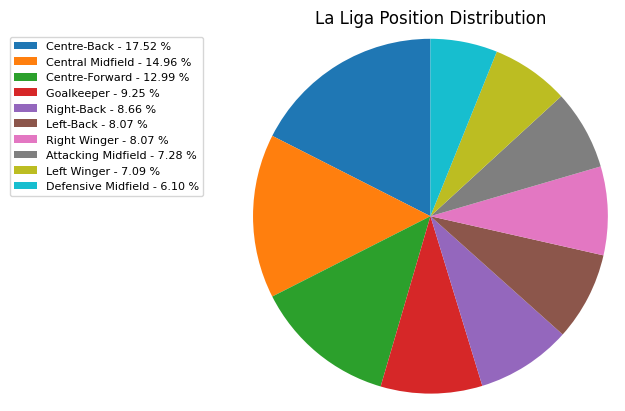

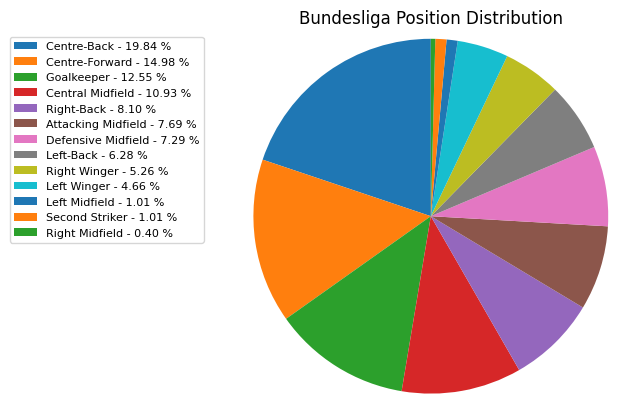

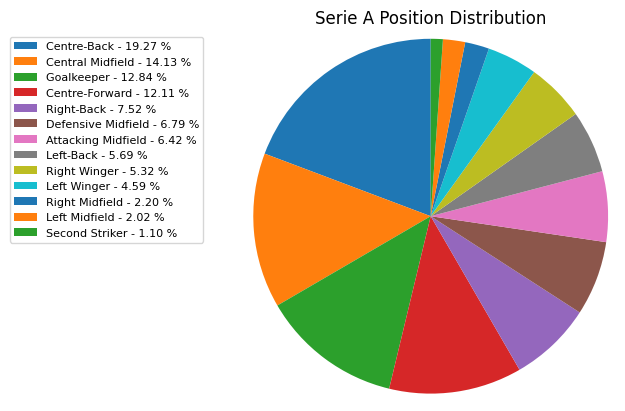

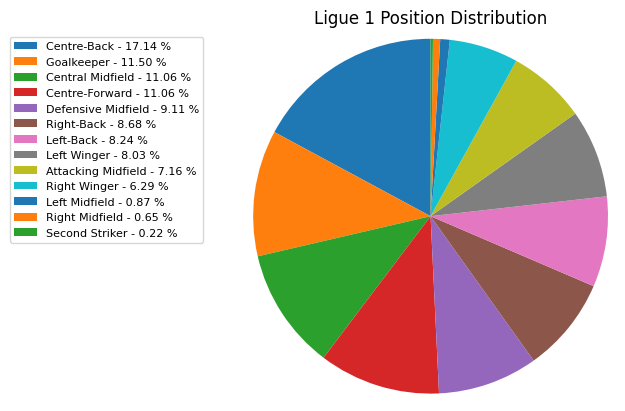

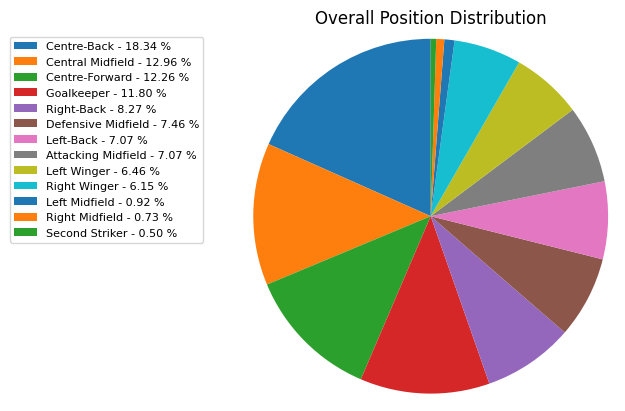

In [31]:
def get_pos_dist(pos, title):
    # Count player occurrences for each position
    position_counts = pos.value_counts()

    # Get pie chart slice labels from the index of position_counts
    x = position_counts.index.to_numpy()  # Convert index to NumPy array

    # Get pie chart slice values from the values of position_counts
    y = position_counts.to_numpy()

    porcent = 100.*y/y.sum()

    patches, texts = plt.pie(y, startangle=90, radius=1.2)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    plt.title(title)
    plt.show()
get_pos_dist(prem_player_data_df["Position"], "Premier League Position Distribution")
get_pos_dist(laliga_player_data_df["Position"], "La Liga Position Distribution")
get_pos_dist(bundesliga_player_data_df["Position"], "Bundesliga Position Distribution")
get_pos_dist(serie_a_player_data_df["Position"], "Serie A Position Distribution")
get_pos_dist(ligue_1_player_data_df["Position"], "Ligue 1 Position Distribution")
get_pos_dist(combined_df["Position"], "Overall Position Distribution")

## Frequency of Injury in Top 5 Leagues

In [32]:
def get_injury_stats(df):
    injuries = df['Injuries']
    injured = 0
    not_injured = 0
    for injury in injuries:
        # Convert sting to dictionary
#         print(injury)
#         injury = eval(injury)
        if len(injury) == 0:
            not_injured += 1
        else:
            injured += 1
    return injured, not_injured

prem_injured, prem_not_injured = get_injury_stats(prem_player_data_df)
laliga_injured, laliga_not_injured = get_injury_stats(laliga_player_data_df)
bundesliga_injured, bundesliga_not_injured = get_injury_stats(bundesliga_player_data_df)
serie_a_injured, serie_a_not_injured = get_injury_stats(serie_a_player_data_df)
ligue_1_injured, ligue_1_not_injured = get_injury_stats(ligue_1_player_data_df)
overall_injured, overall_not_injured = get_injury_stats(combined_df)

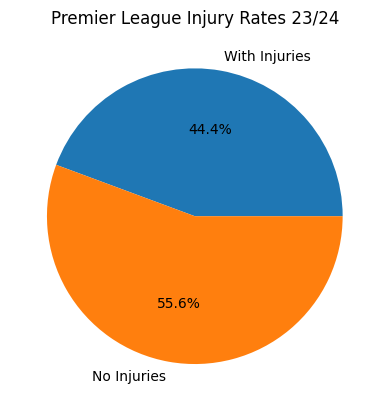

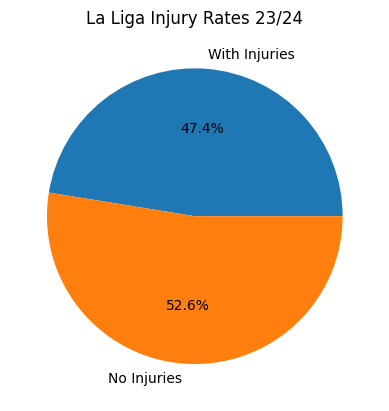

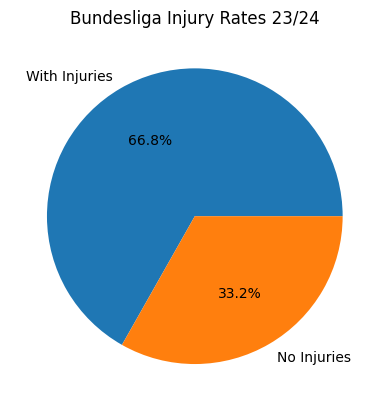

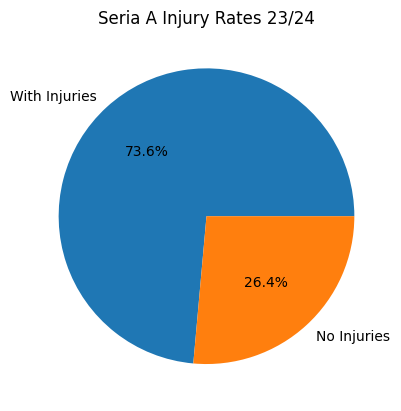

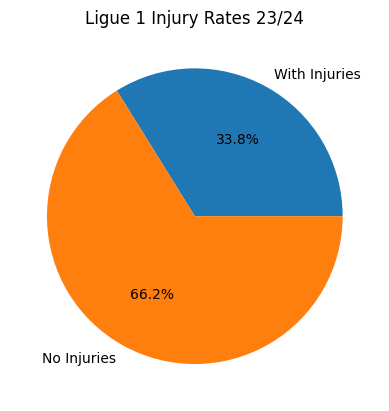

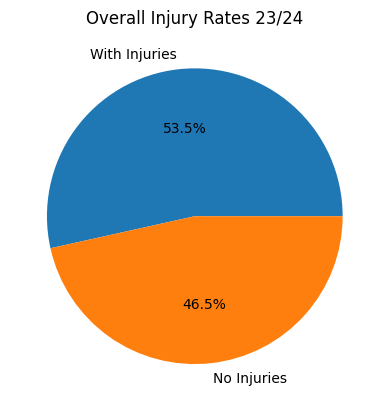

In [33]:
def get_injury_chart(injured, not_injured, title):
    total = injured + not_injured
    sizes = np.array([injured / total, not_injured / total])
    labels = ["With Injuries", "No Injuries"]
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    
get_injury_chart(prem_injured, prem_not_injured, "Premier League Injury Rates 23/24")
get_injury_chart(laliga_injured, laliga_not_injured, "La Liga Injury Rates 23/24")
get_injury_chart(bundesliga_injured, bundesliga_not_injured, "Bundesliga Injury Rates 23/24")
get_injury_chart(serie_a_injured, serie_a_not_injured, "Seria A Injury Rates 23/24")
get_injury_chart(ligue_1_injured, ligue_1_not_injured, "Ligue 1 Injury Rates 23/24")
get_injury_chart(overall_injured, overall_not_injured, "Overall Injury Rates 23/24")

## Distribution of Appearances Made against Age

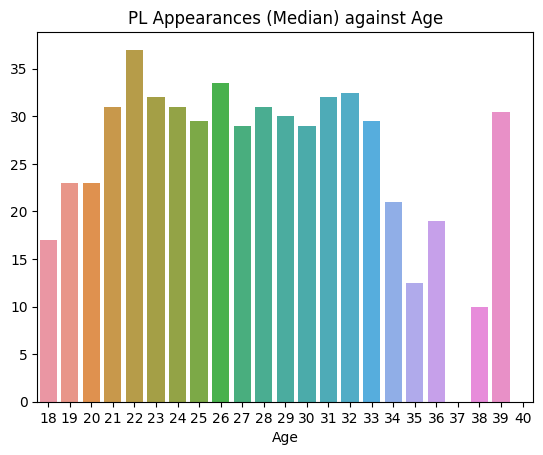

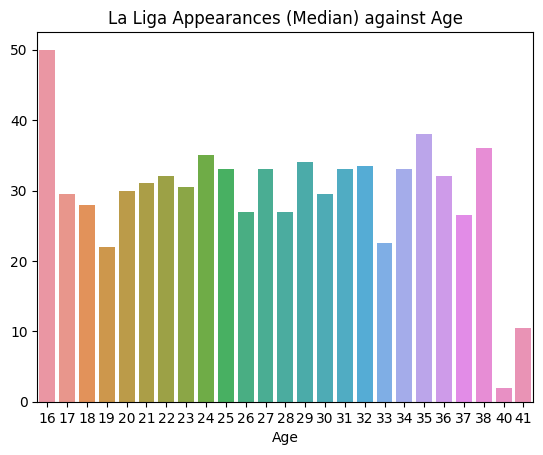

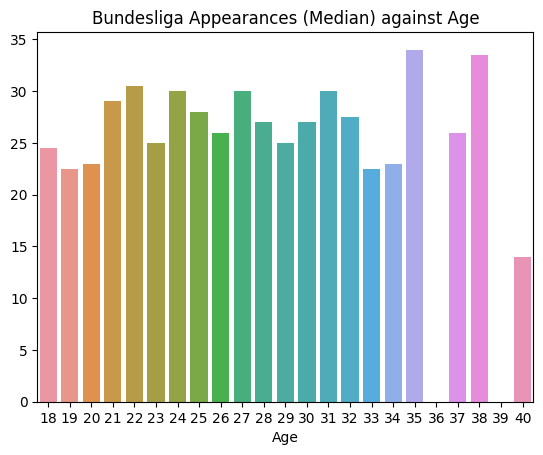

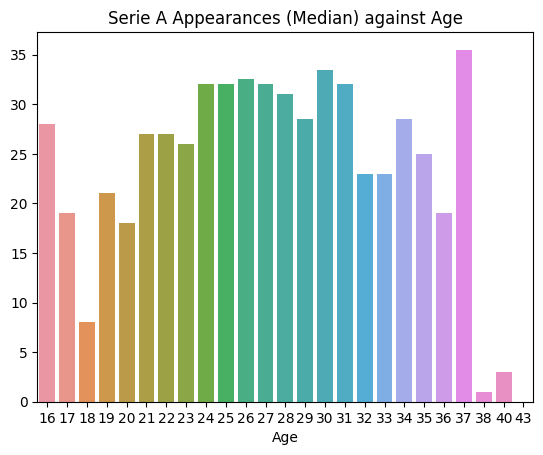

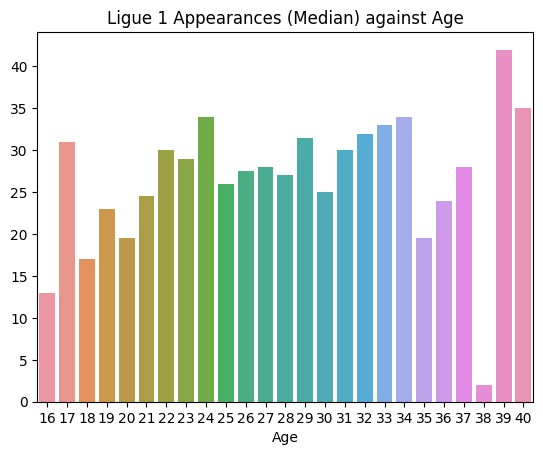

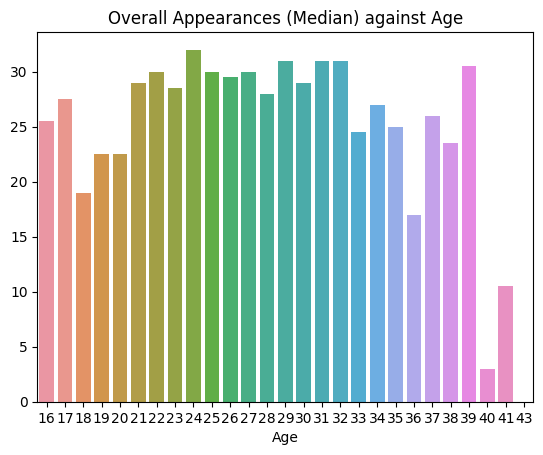

In [34]:
def get_age_appearance_dist(df, title):
    avg_appearances_by_age = df.groupby('Age')['Appearances'].median()
    sns.barplot(x=avg_appearances_by_age.index, y=avg_appearances_by_age.values, errorbar="sd").set(title=title)
    plt.show()
    
get_age_appearance_dist(prem_player_data_df, "PL Appearances (Median) against Age")
get_age_appearance_dist(laliga_player_data_df, "La Liga Appearances (Median) against Age")
get_age_appearance_dist(bundesliga_player_data_df, "Bundesliga Appearances (Median) against Age")
get_age_appearance_dist(serie_a_player_data_df, "Serie A Appearances (Median) against Age")
get_age_appearance_dist(ligue_1_player_data_df, "Ligue 1 Appearances (Median) against Age")
get_age_appearance_dist(combined_df, "Overall Appearances (Median) against Age")

## Distribution of Appearances Made against Playing Position

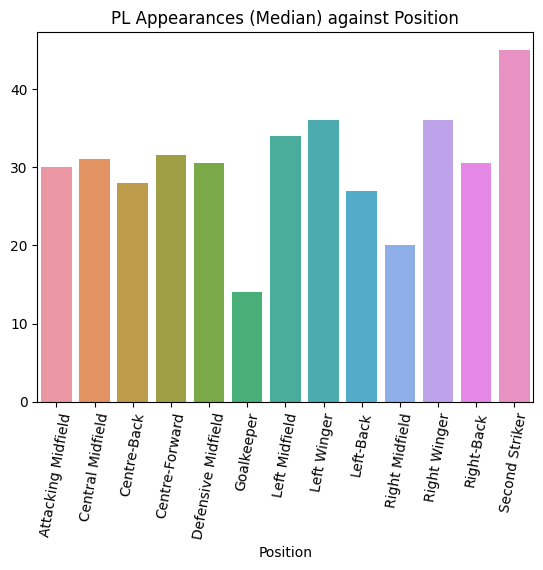

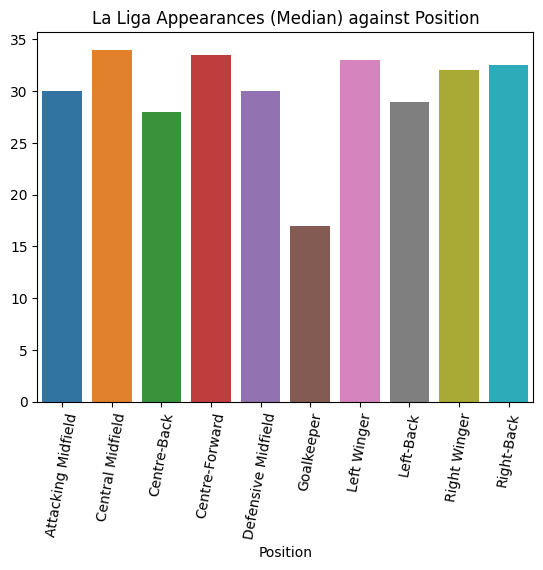

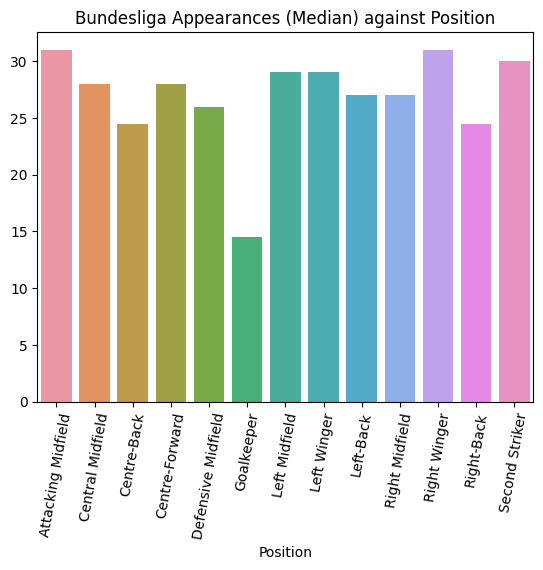

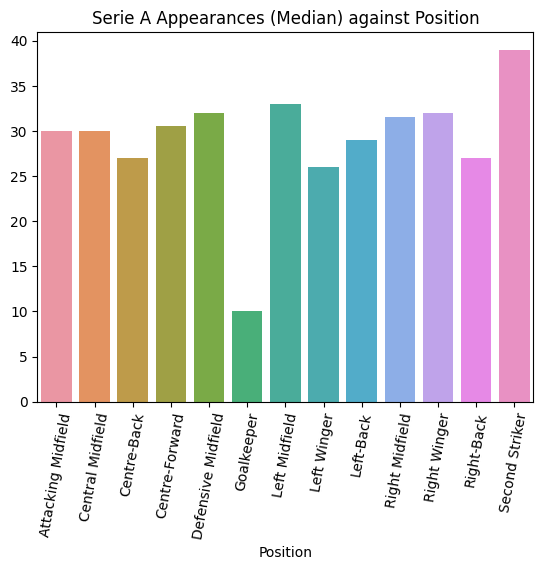

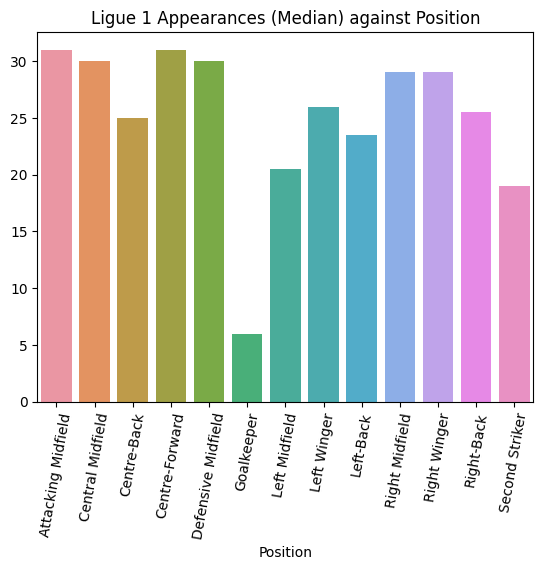

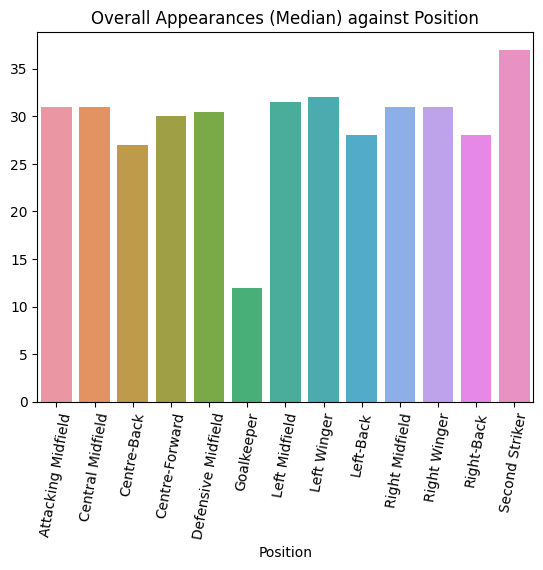

In [35]:
def get_pos_appearance_dist(df, title):
    avg_appearances_by_age = df.groupby('Position')['Appearances'].median()
    sns.barplot(x=avg_appearances_by_age.index, y=avg_appearances_by_age.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_pos_appearance_dist(prem_player_data_df, "PL Appearances (Median) against Position")
get_pos_appearance_dist(laliga_player_data_df, "La Liga Appearances (Median) against Position")
get_pos_appearance_dist(bundesliga_player_data_df, "Bundesliga Appearances (Median) against Position")
get_pos_appearance_dist(serie_a_player_data_df, "Serie A Appearances (Median) against Position")
get_pos_appearance_dist(ligue_1_player_data_df, "Ligue 1 Appearances (Median) against Position")
get_pos_appearance_dist(combined_df, "Overall Appearances (Median) against Position")

## Distribution of **Days Out due to Injury** against **Age**

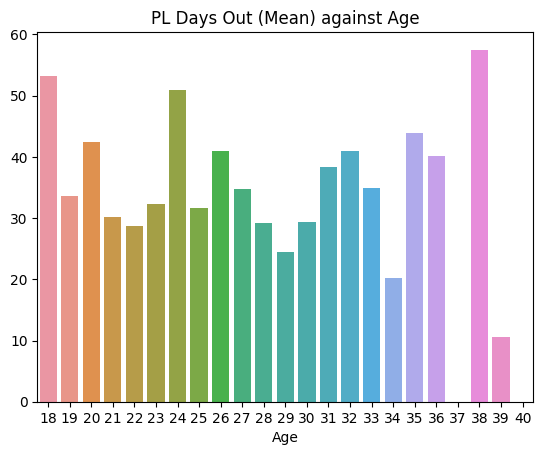

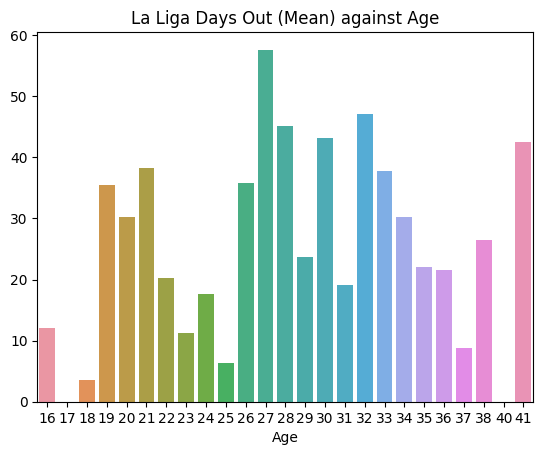

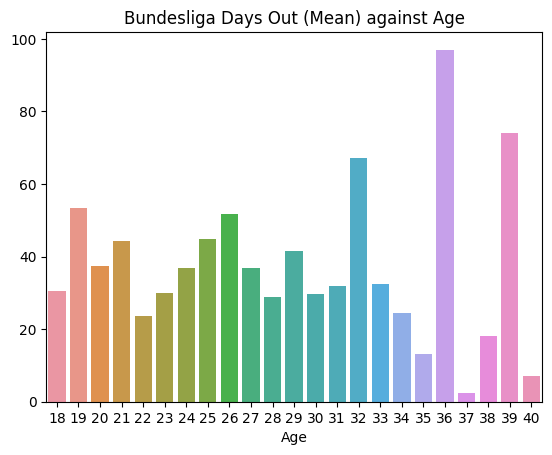

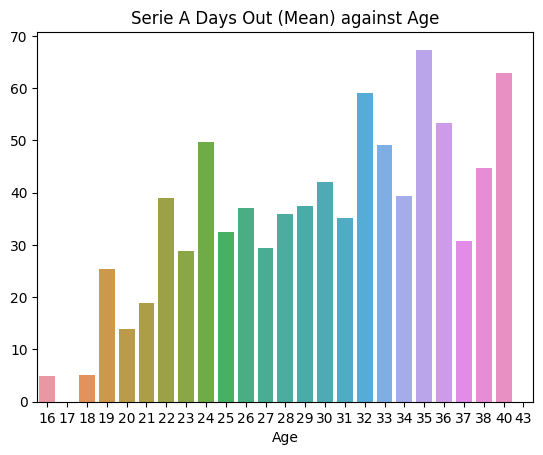

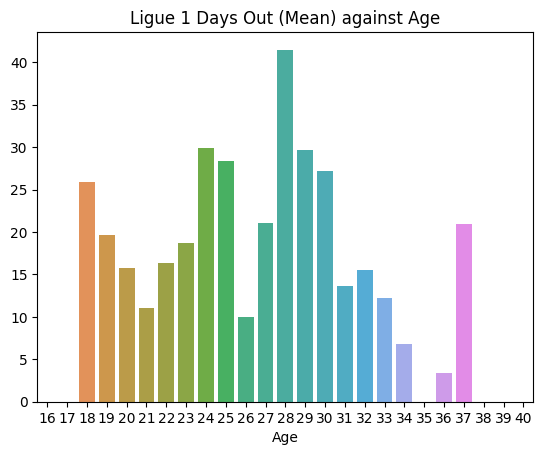

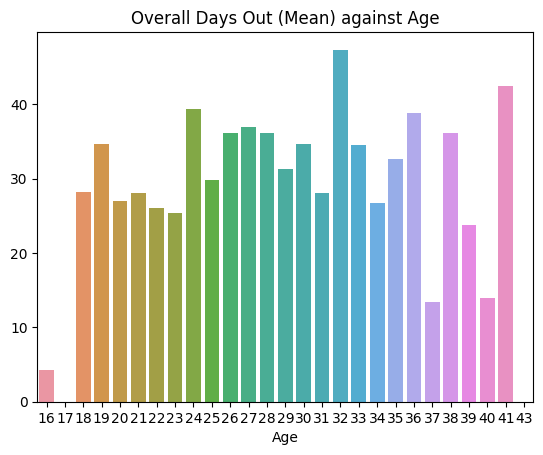

In [36]:
def get_age_days_out_dist(df, title):
    avg_days_out_by_age = df.groupby('Age')['Total Days'].mean()
    sns.barplot(x=avg_days_out_by_age.index, y=avg_days_out_by_age.values, errorbar="sd").set(title=title)
    plt.show()
    
get_age_days_out_dist(prem_player_data_df, "PL Days Out (Mean) against Age")
get_age_days_out_dist(laliga_player_data_df, "La Liga Days Out (Mean) against Age")
get_age_days_out_dist(bundesliga_player_data_df, "Bundesliga Days Out (Mean) against Age")
get_age_days_out_dist(serie_a_player_data_df, "Serie A Days Out (Mean) against Age")
get_age_days_out_dist(ligue_1_player_data_df, "Ligue 1 Days Out (Mean) against Age")
get_age_days_out_dist(combined_df, "Overall Days Out (Mean) against Age")

## Distribution of **Days Out due to Injury** against **Position**

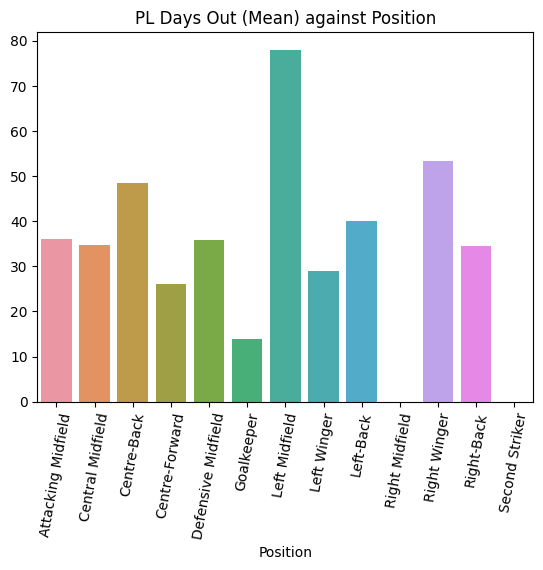

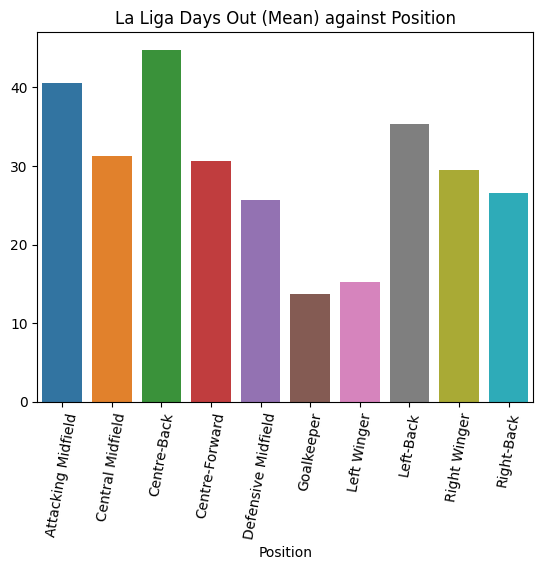

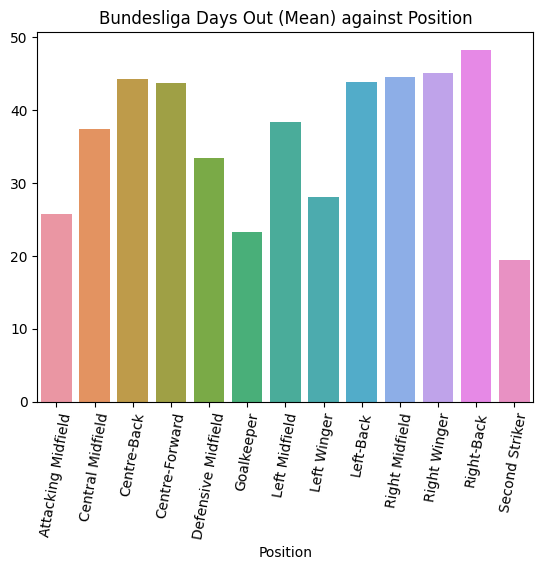

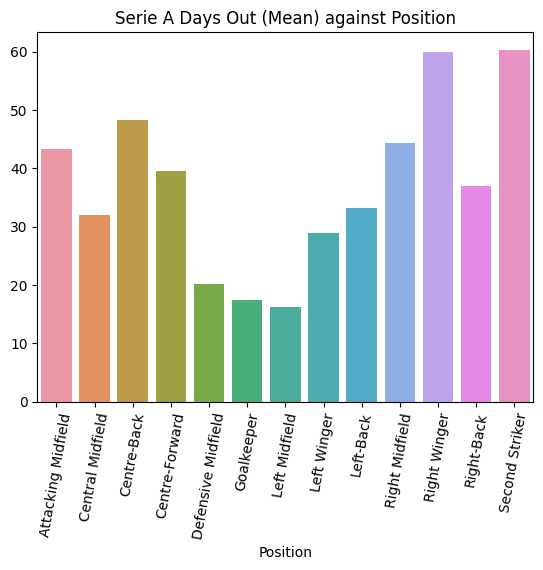

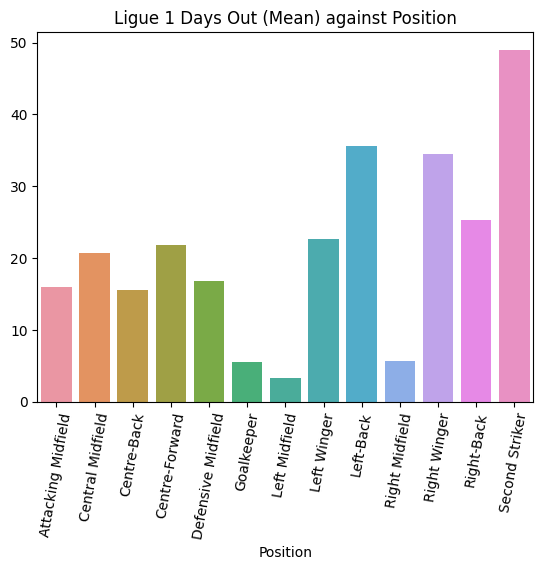

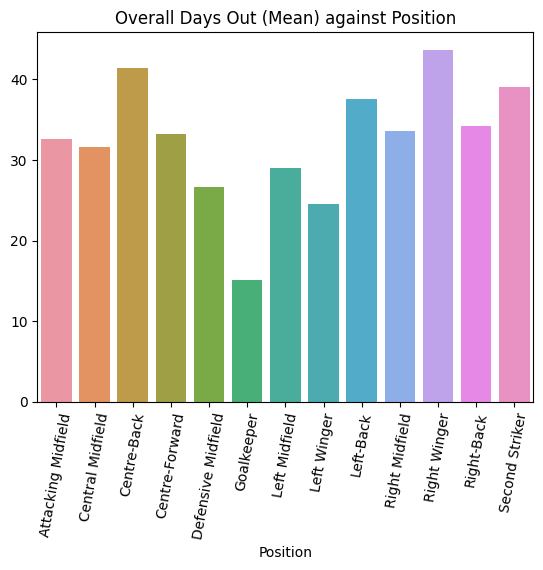

In [37]:
def get_pos_days_out_dist(df, title):
    avg_days_out_by_age = df.groupby('Position')['Total Days'].mean()
    sns.barplot(x=avg_days_out_by_age.index, y=avg_days_out_by_age.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_pos_days_out_dist(prem_player_data_df, "PL Days Out (Mean) against Position")
get_pos_days_out_dist(laliga_player_data_df, "La Liga Days Out (Mean) against Position")
get_pos_days_out_dist(bundesliga_player_data_df, "Bundesliga Days Out (Mean) against Position")
get_pos_days_out_dist(serie_a_player_data_df, "Serie A Days Out (Mean) against Position")
get_pos_days_out_dist(ligue_1_player_data_df, "Ligue 1 Days Out (Mean) against Position")
get_pos_days_out_dist(combined_df, "Overall Days Out (Mean) against Position")

## Distribution of **Days Out due to Injury** against **Position (General)**

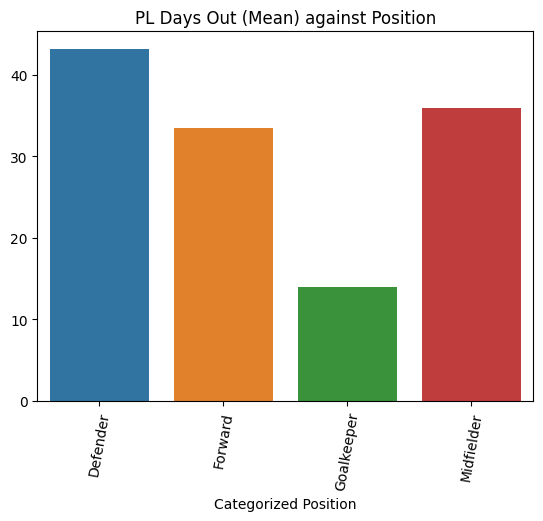

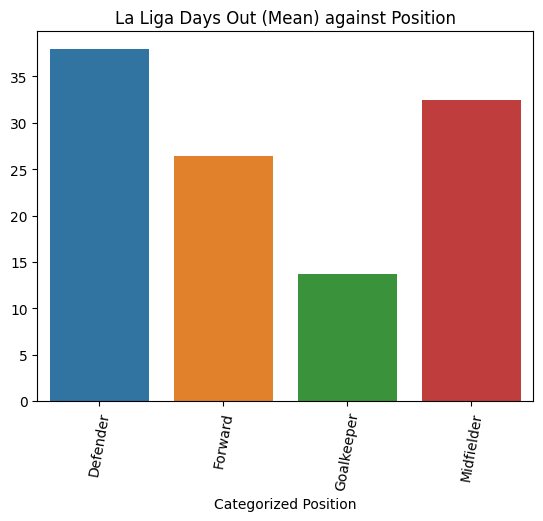

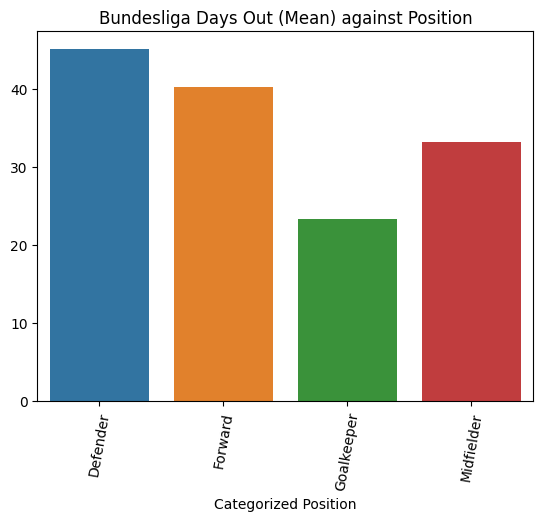

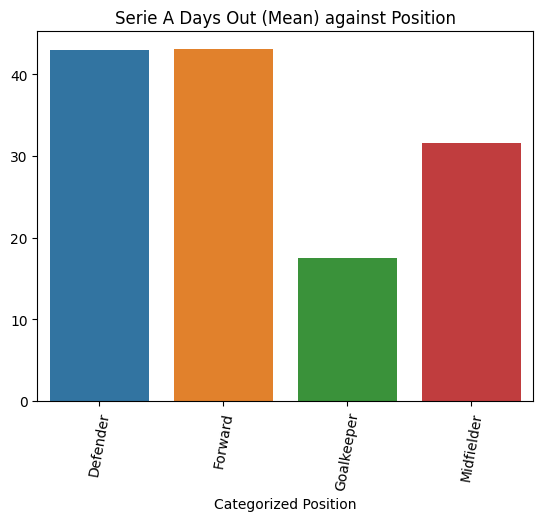

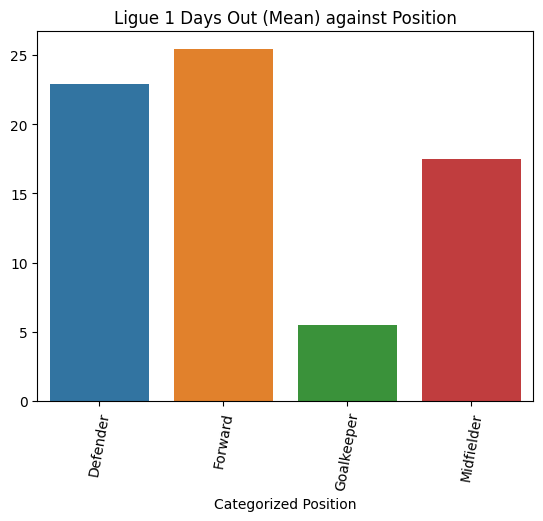

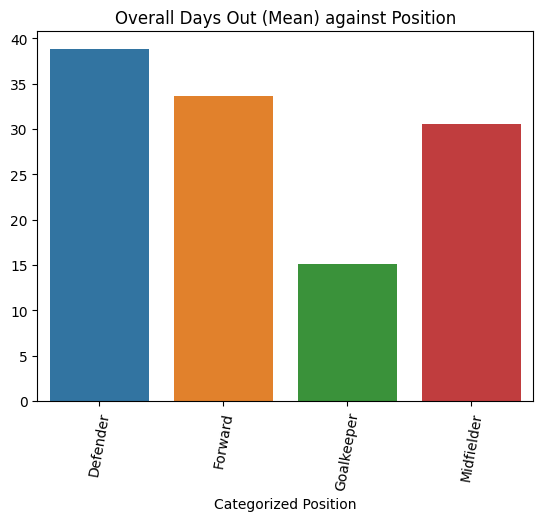

In [38]:
def get_cat_pos_days_out_dist(df, title):
    avg_days_out_by_age = df.groupby('Categorized Position')['Total Days'].mean()
    sns.barplot(x=avg_days_out_by_age.index, y=avg_days_out_by_age.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_cat_pos_days_out_dist(prem_player_data_df, "PL Days Out (Mean) against Position")
get_cat_pos_days_out_dist(laliga_player_data_df, "La Liga Days Out (Mean) against Position")
get_cat_pos_days_out_dist(bundesliga_player_data_df, "Bundesliga Days Out (Mean) against Position")
get_cat_pos_days_out_dist(serie_a_player_data_df, "Serie A Days Out (Mean) against Position")
get_cat_pos_days_out_dist(ligue_1_player_data_df, "Ligue 1 Days Out (Mean) against Position")
get_cat_pos_days_out_dist(combined_df, "Overall Days Out (Mean) against Position")

## Distribution of **Minutes Played** against **Position**

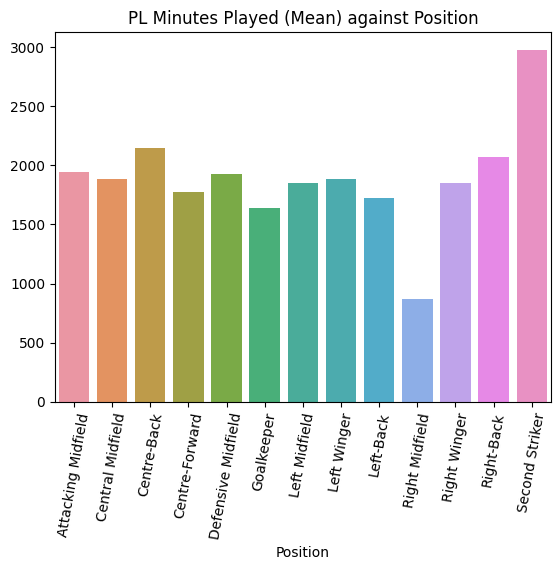

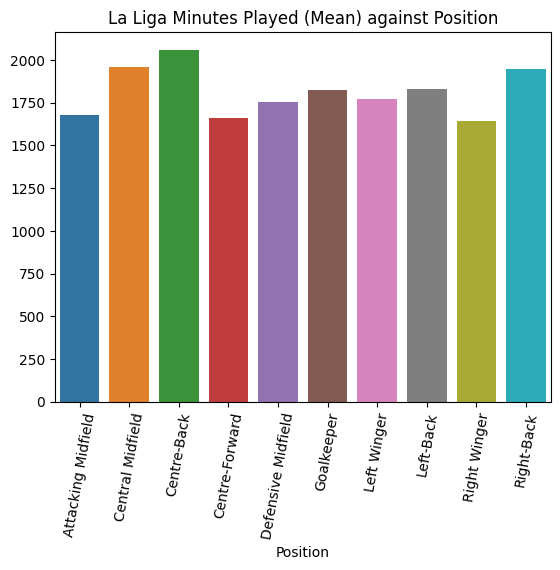

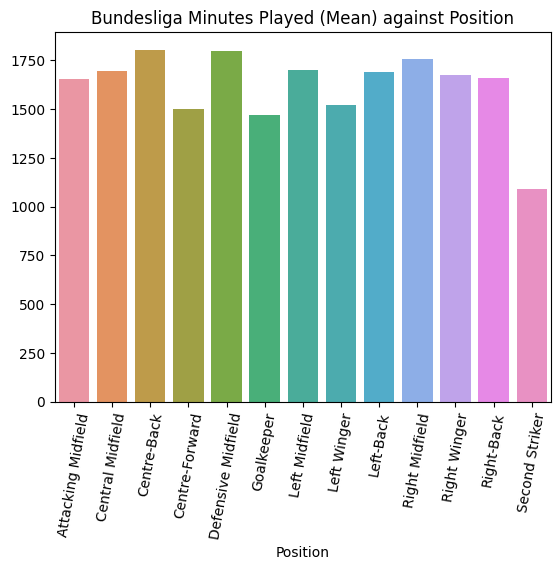

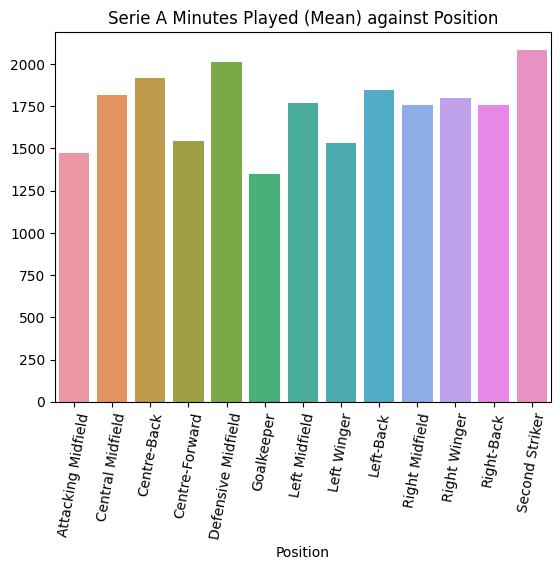

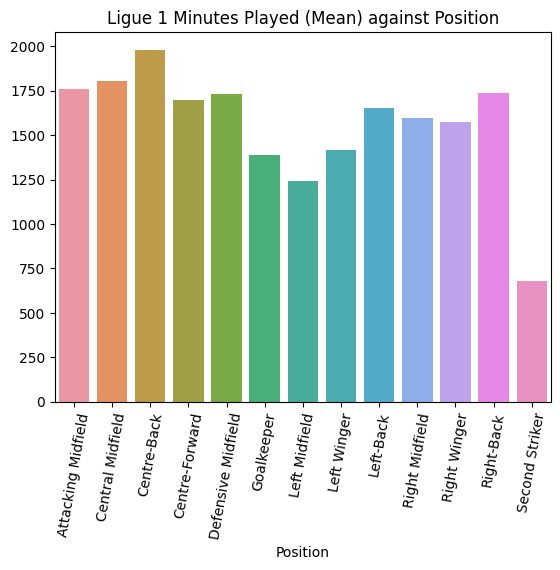

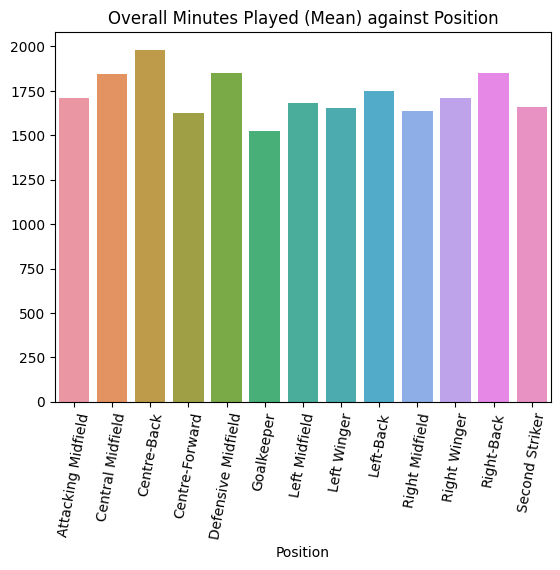

In [39]:
def get_minutes_played_pos_dist(df, title):
    avg_minutes_played_by_age = df.groupby('Position')['Minutes Played Total 23/24:'].mean()
    sns.barplot(x=avg_minutes_played_by_age.index, y=avg_minutes_played_by_age.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_minutes_played_pos_dist(prem_player_data_df, "PL Minutes Played (Mean) against Position")
get_minutes_played_pos_dist(laliga_player_data_df, "La Liga Minutes Played (Mean) against Position")
get_minutes_played_pos_dist(bundesliga_player_data_df, "Bundesliga Minutes Played (Mean) against Position")
get_minutes_played_pos_dist(serie_a_player_data_df, "Serie A Minutes Played (Mean) against Position")
get_minutes_played_pos_dist(ligue_1_player_data_df, "Ligue 1 Minutes Played (Mean) against Position")
get_minutes_played_pos_dist(combined_df, "Overall Minutes Played (Mean) against Position")

## Distribution of **Minutes Played** against **Position (General)**

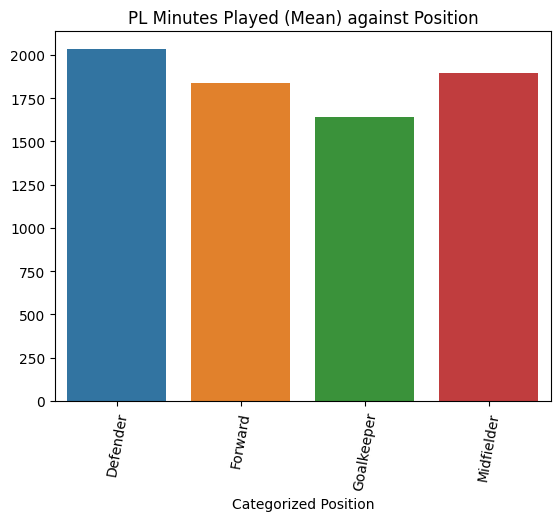

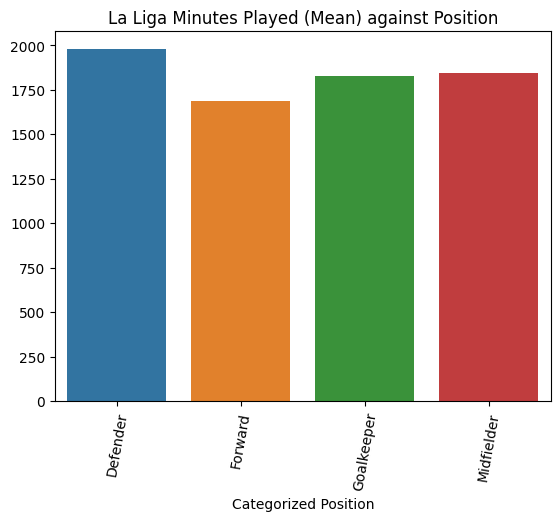

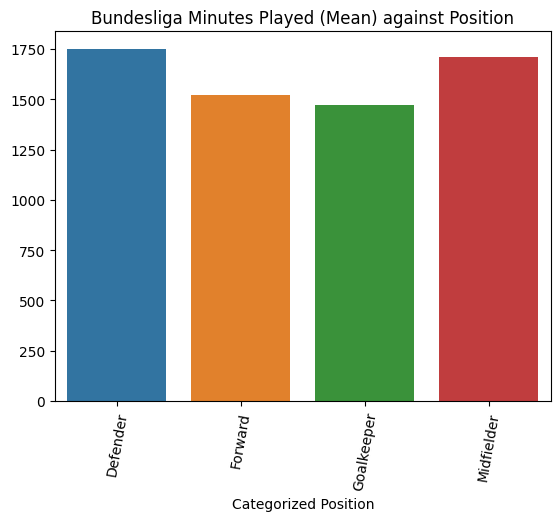

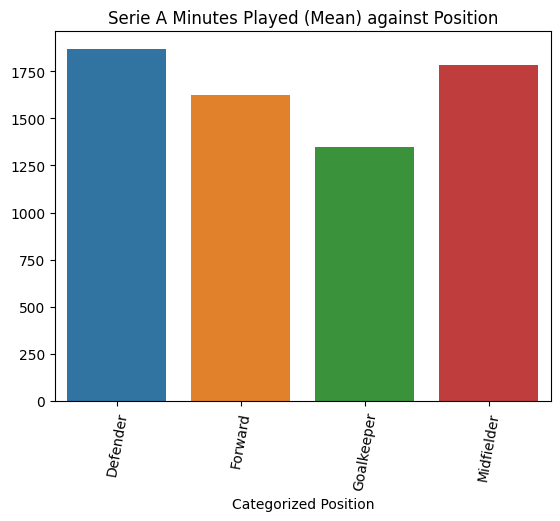

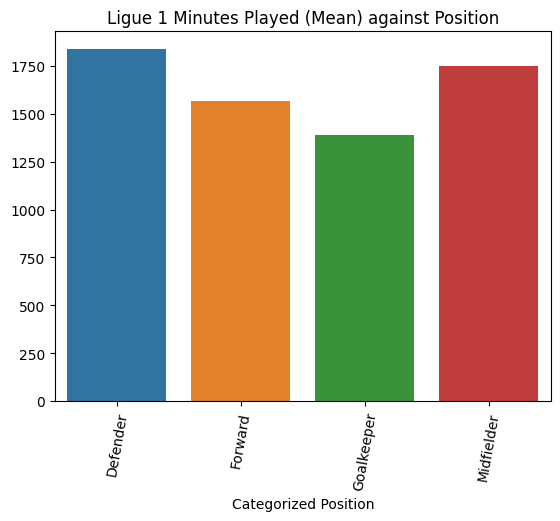

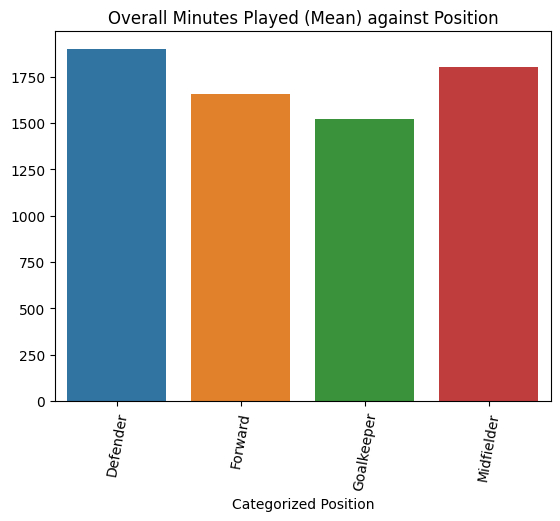

In [40]:
def get_minutes_played_cat_pos_dist(df, title):
    avg_minutes_played_by_age = df.groupby('Categorized Position')['Minutes Played Total 23/24:'].mean()
    sns.barplot(x=avg_minutes_played_by_age.index, y=avg_minutes_played_by_age.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_minutes_played_cat_pos_dist(prem_player_data_df, "PL Minutes Played (Mean) against Position")
get_minutes_played_cat_pos_dist(laliga_player_data_df, "La Liga Minutes Played (Mean) against Position")
get_minutes_played_cat_pos_dist(bundesliga_player_data_df, "Bundesliga Minutes Played (Mean) against Position")
get_minutes_played_cat_pos_dist(serie_a_player_data_df, "Serie A Minutes Played (Mean) against Position")
get_minutes_played_cat_pos_dist(ligue_1_player_data_df, "Ligue 1 Minutes Played (Mean) against Position")
get_minutes_played_cat_pos_dist(combined_df, "Overall Minutes Played (Mean) against Position")

## Scatter Plot of **Days Out due to Injury** against **Minutes Played**

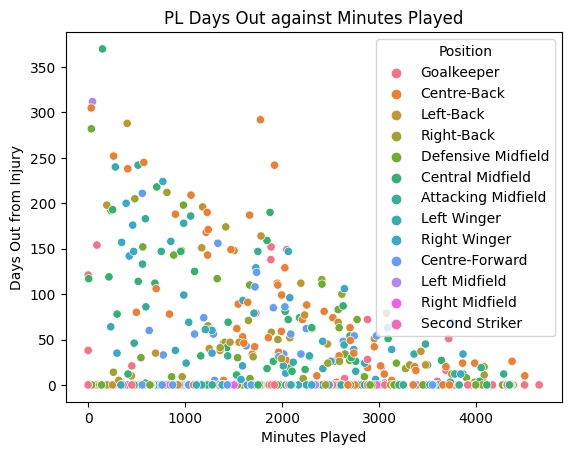

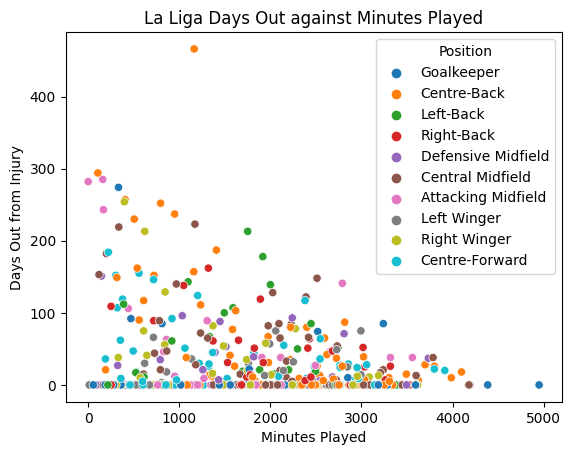

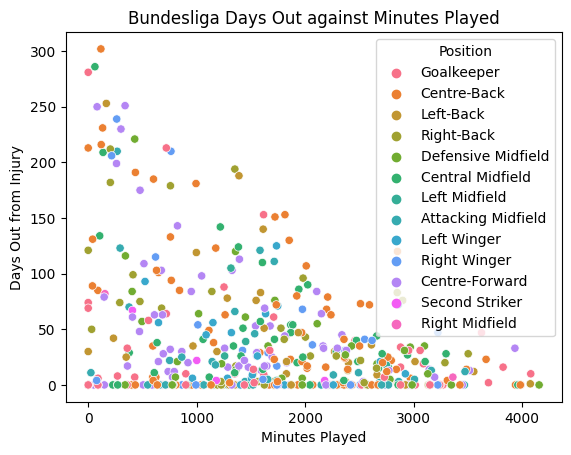

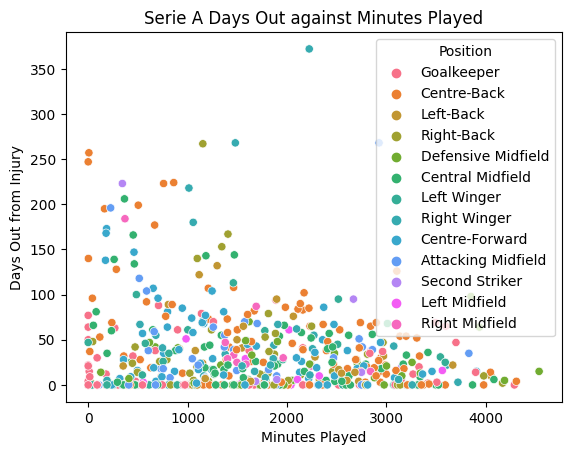

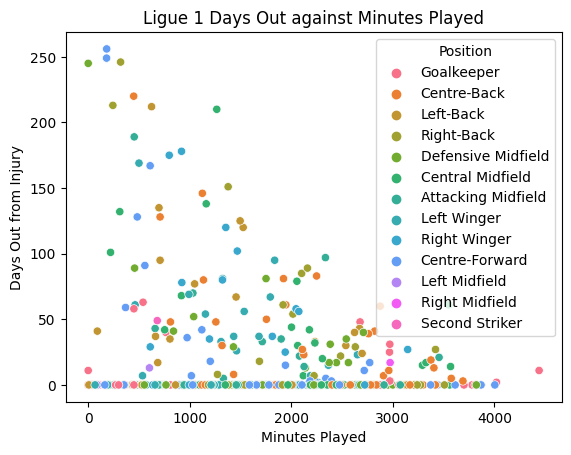

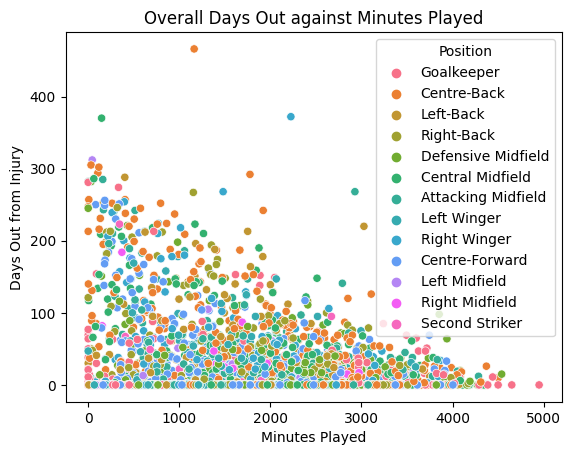

In [41]:
def get_minutes_played_days_out(df, title):
    # Assuming your DataFrame is named 'df'
    sns.scatterplot(data=df, x='Minutes Played Total 23/24:', y='Total Days', hue="Position").set(title=title)
    plt.xlabel('Minutes Played')
    plt.ylabel('Days Out from Injury')
    plt.show()
    
get_minutes_played_days_out(prem_player_data_df, "PL Days Out against Minutes Played")
get_minutes_played_days_out(laliga_player_data_df, "La Liga Days Out against Minutes Played")
get_minutes_played_days_out(bundesliga_player_data_df, "Bundesliga Days Out against Minutes Played")
get_minutes_played_days_out(serie_a_player_data_df, "Serie A Days Out against Minutes Played")
get_minutes_played_days_out(ligue_1_player_data_df, "Ligue 1 Days Out against Minutes Played")
get_minutes_played_days_out(combined_df, "Overall Days Out against Minutes Played")

## Correlation matrix of selected attributes

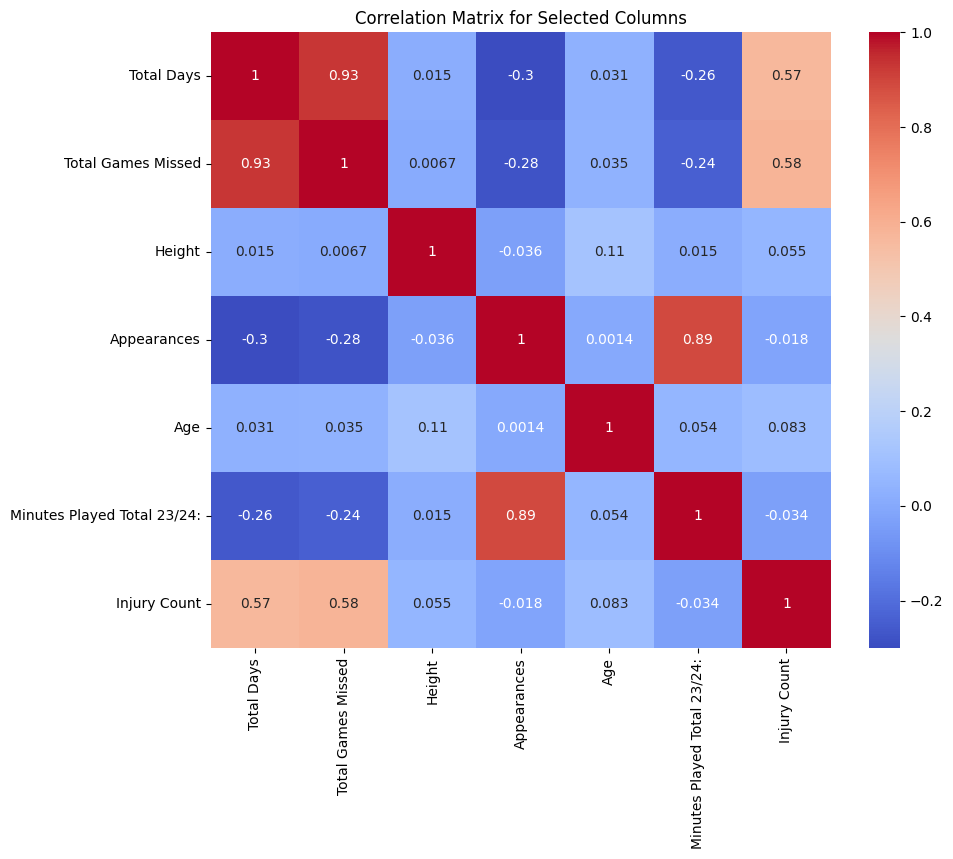

In [42]:
# Select desired columns for correlation
columns_to_correlate = ['Total Days', 'Total Games Missed', 'Height', 'Appearances', 'Age', 'Minutes Played Total 23/24:', 'Injury Count']  # Replace with your desired columns

# Calculate correlation matrix for selected columns
correlation_matrix = combined_df[columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Columns')
plt.show()

## Types of injuries in Top 5 Leagues

In [43]:
def count_injury_occurrences(df, title):
    """
    Counts the occurrences of each injury type across all players.

    Args:
      df (pandas.DataFrame): The DataFrame containing the injury column.
      injury_column (str): The name of the injury column.

    Returns:
      pandas.Series: A Series containing the count of each injury type.
    """

    from collections import Counter
    all_injuries = [injury for sublist in df['Type of Injury'] for injury in sublist]
    injury_counts = Counter(all_injuries)
    
    # Sort injury counts by count in descending order
    sorted_injury_counts = injury_counts.most_common()

    # Convert sorted injury counts to a DataFrame for plotting
    injury_counts_df = pd.DataFrame({'Injury Type': [item[0] for item in sorted_injury_counts], 'Count': [item[1] for item in sorted_injury_counts]})

    # Create a bar chart
    sns.barplot(injury_counts_df, x='Injury Type', y='Count').set(title=title)
    plt.xticks(rotation=90, fontsize=5)
    plt.show()

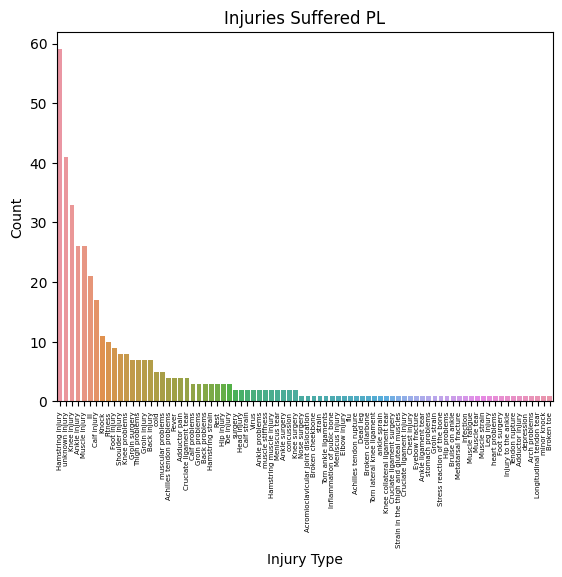

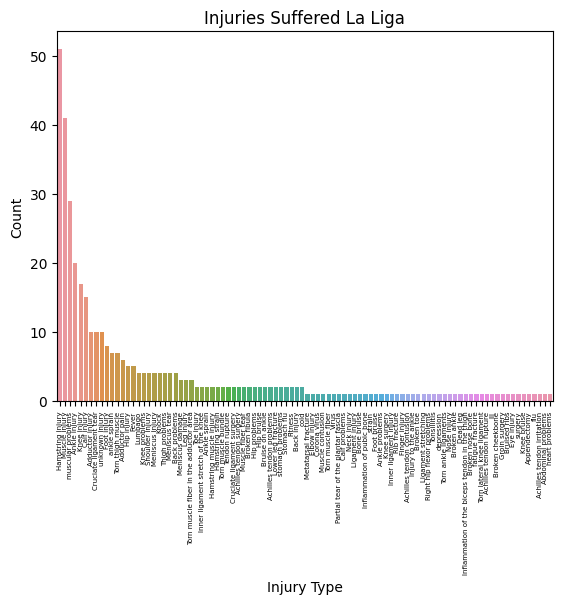

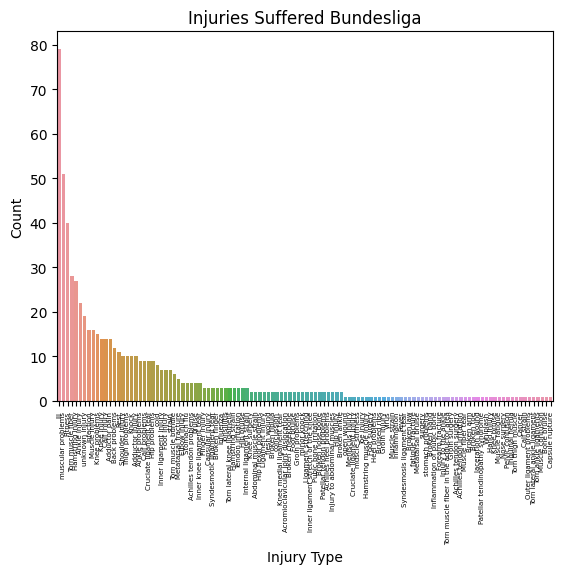

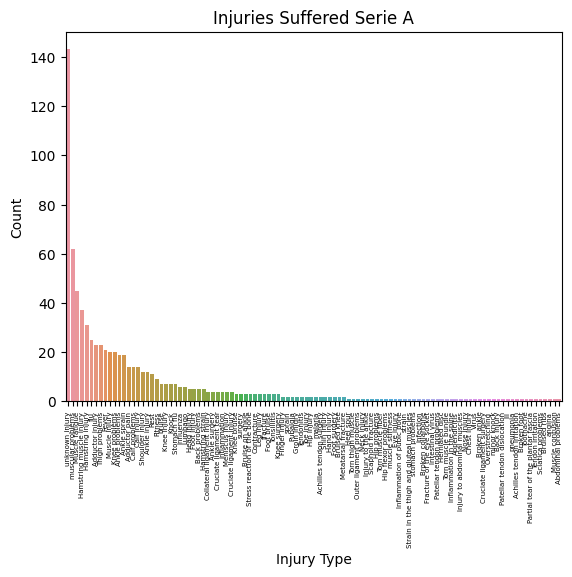

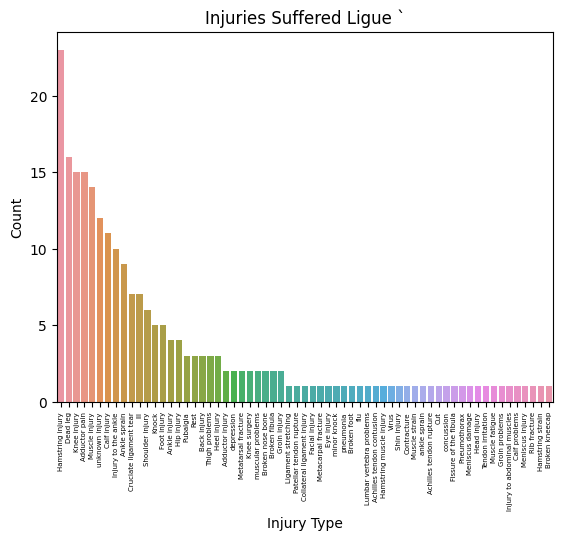

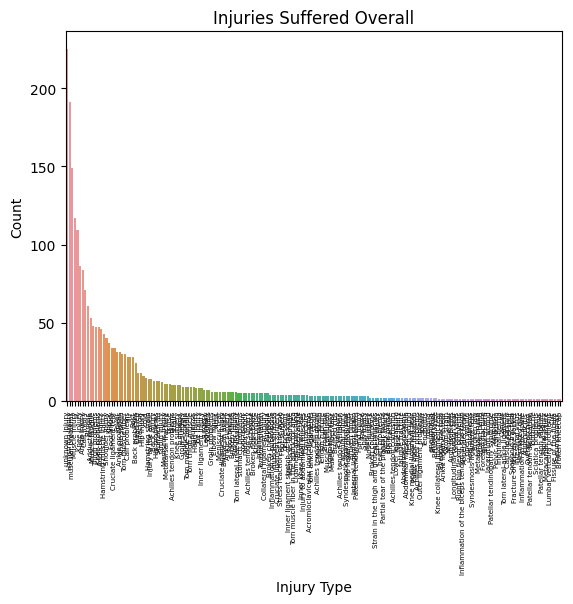

In [44]:
count_injury_occurrences(prem_player_data_df, "Injuries Suffered PL")
count_injury_occurrences(laliga_player_data_df, "Injuries Suffered La Liga")
count_injury_occurrences(bundesliga_player_data_df, "Injuries Suffered Bundesliga")
count_injury_occurrences(serie_a_player_data_df, "Injuries Suffered Serie A")
count_injury_occurrences(ligue_1_player_data_df, "Injuries Suffered Ligue `")
count_injury_occurrences(combined_df, "Injuries Suffered Overall")

## Count of (General) Injuries in Top 5 Leagues

In [45]:
def count_catergorised_injury_occurrences(df, title):
    """
    Counts the occurrences of each injury type across all players.

    Args:
      df (pandas.DataFrame): The DataFrame containing the injury column.
      injury_column (str): The name of the injury column.

    Returns:
      pandas.Series: A Series containing the count of each injury type.
    """

    from collections import Counter
    all_injuries = [injury for sublist in df['Categorized Injuries'] for injury in sublist]
    injury_counts = Counter(all_injuries)
    
    # Sort injury counts by count in descending order
    sorted_injury_counts = injury_counts.most_common()

    # Convert sorted injury counts to a DataFrame for plotting
    injury_counts_df = pd.DataFrame({'Categorized Injury Type': [item[0] for item in sorted_injury_counts], 'Count': [item[1] for item in sorted_injury_counts]})

    # Create a bar chart
    sns.barplot(injury_counts_df, x='Categorized Injury Type', y='Count').set(title=title)
    plt.xticks(rotation=80)
    plt.show()

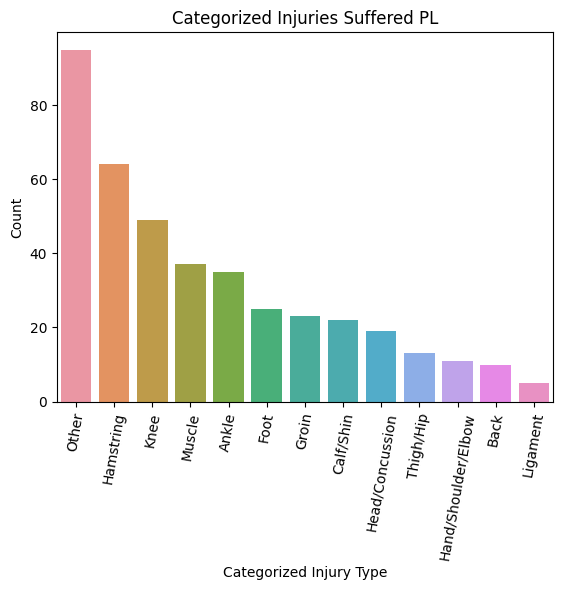

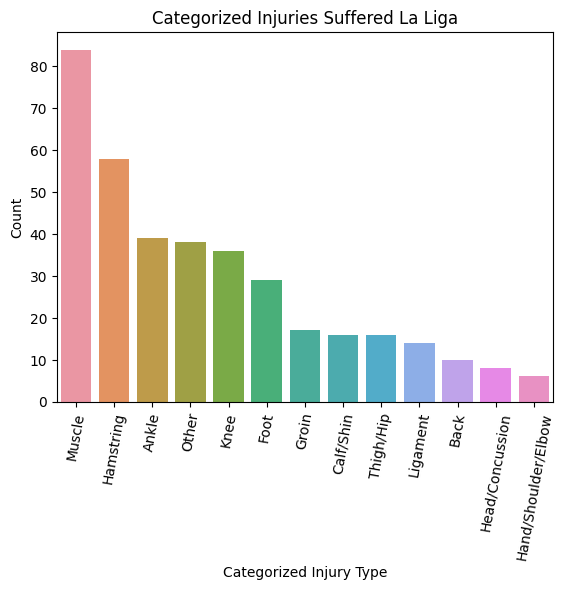

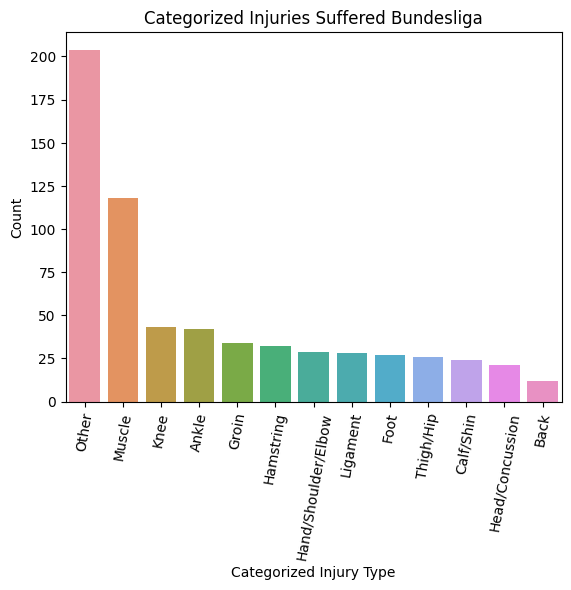

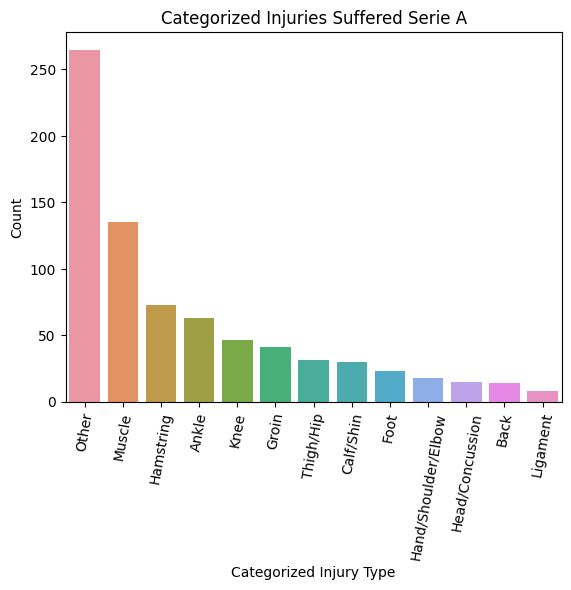

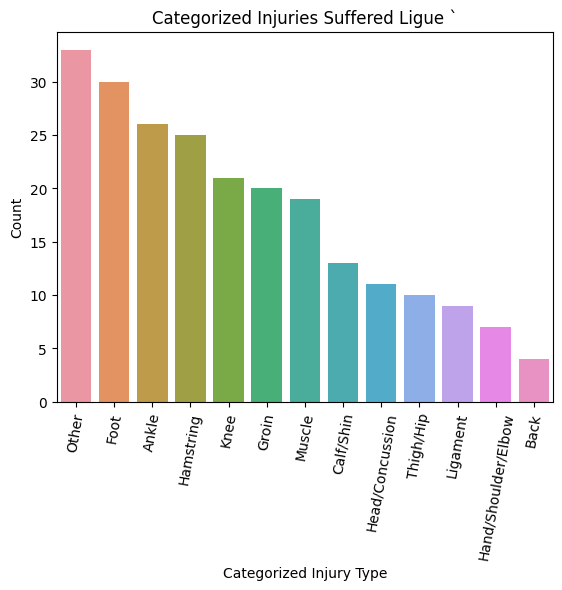

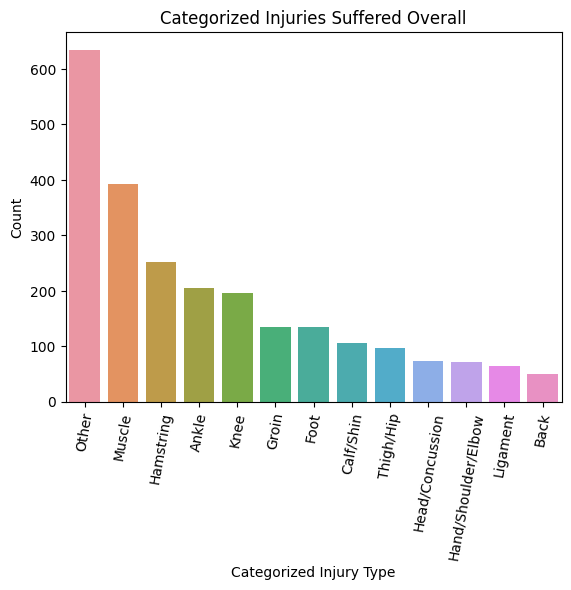

In [46]:
count_catergorised_injury_occurrences(prem_player_data_df, "Categorized Injuries Suffered PL")
count_catergorised_injury_occurrences(laliga_player_data_df, "Categorized Injuries Suffered La Liga")
count_catergorised_injury_occurrences(bundesliga_player_data_df, "Categorized Injuries Suffered Bundesliga")
count_catergorised_injury_occurrences(serie_a_player_data_df, "Categorized Injuries Suffered Serie A")
count_catergorised_injury_occurrences(ligue_1_player_data_df, "Categorized Injuries Suffered Ligue `")
count_catergorised_injury_occurrences(combined_df, "Categorized Injuries Suffered Overall")

## Number of injuries by Position (General)

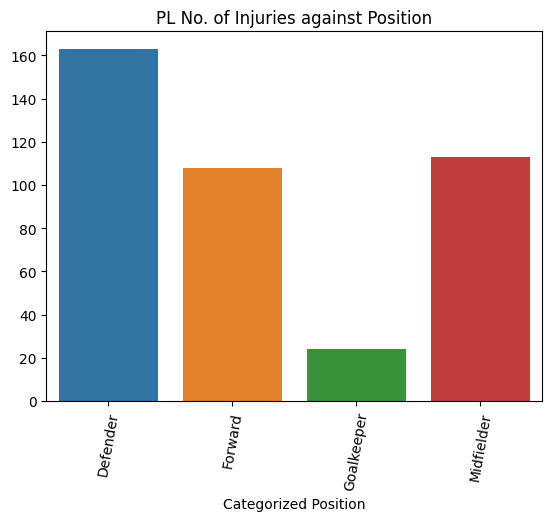

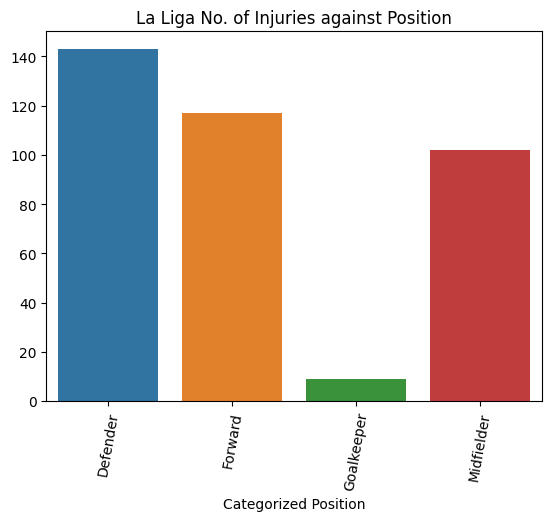

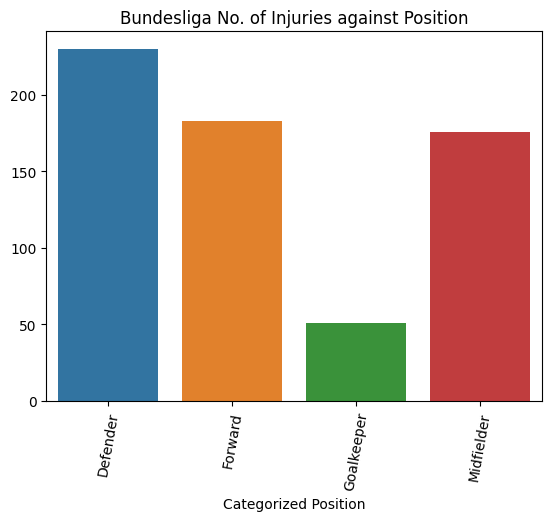

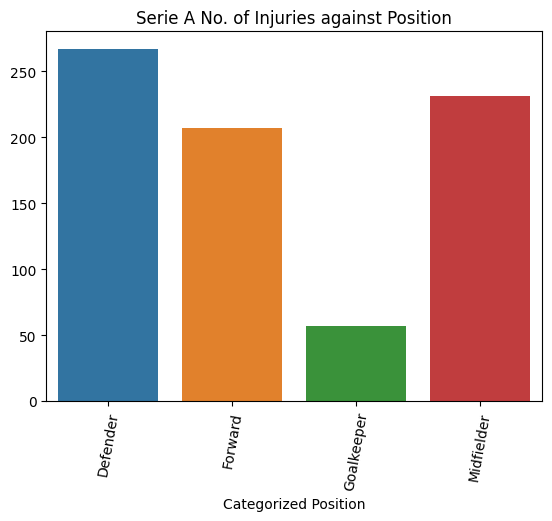

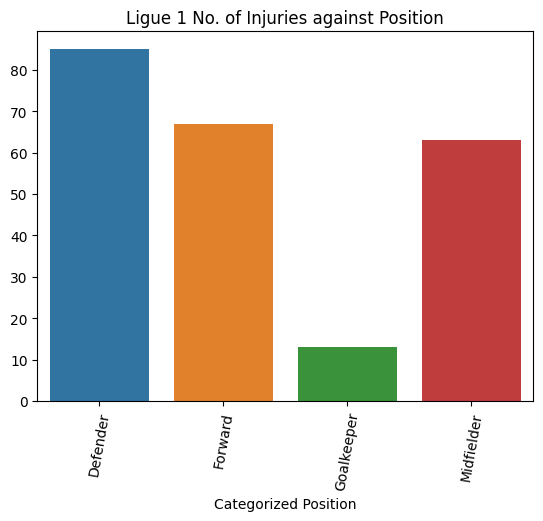

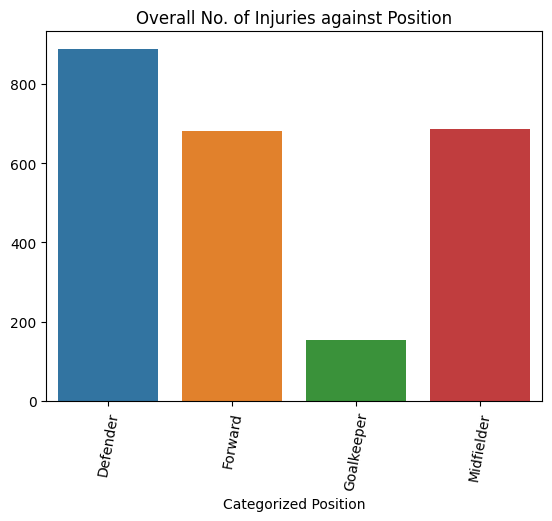

In [47]:
def get_cat_pos_num_injuries_dist(df, title):
    num_injuries_by_cat_pos = df.groupby('Categorized Position')['Injury Count'].sum()
    sns.barplot(x=num_injuries_by_cat_pos.index, y=num_injuries_by_cat_pos.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_cat_pos_num_injuries_dist(prem_player_data_df, "PL No. of Injuries against Position")
get_cat_pos_num_injuries_dist(laliga_player_data_df, "La Liga No. of Injuries against Position")
get_cat_pos_num_injuries_dist(bundesliga_player_data_df, "Bundesliga No. of Injuries against Position")
get_cat_pos_num_injuries_dist(serie_a_player_data_df, "Serie A No. of Injuries against Position")
get_cat_pos_num_injuries_dist(ligue_1_player_data_df, "Ligue 1 No. of Injuries against Position")
get_cat_pos_num_injuries_dist(combined_df, "Overall No. of Injuries against Position")

## Average cost (in millions) of injury by position

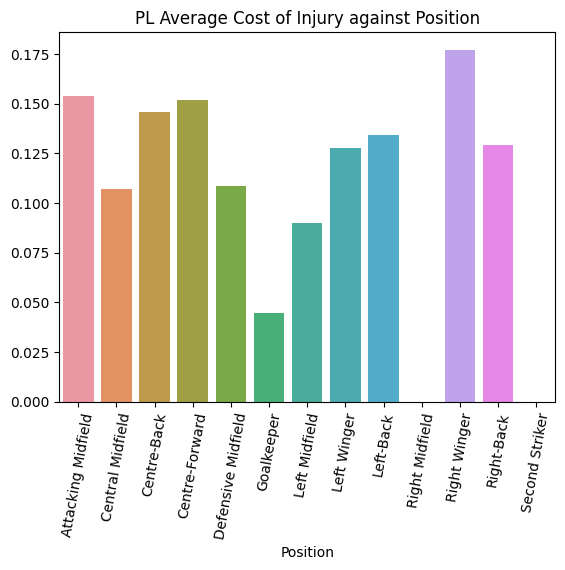

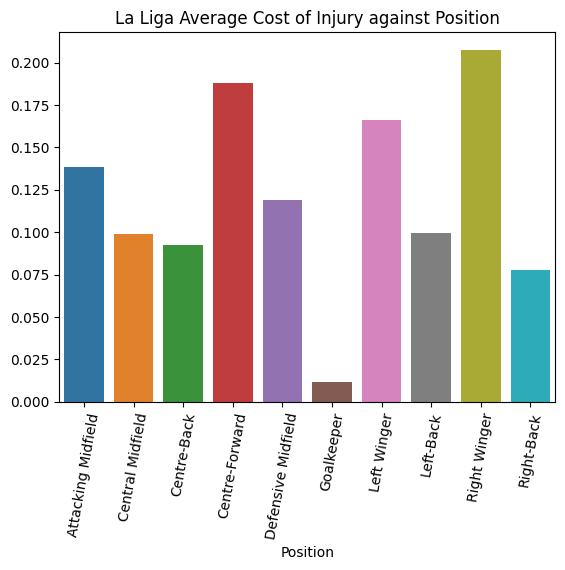

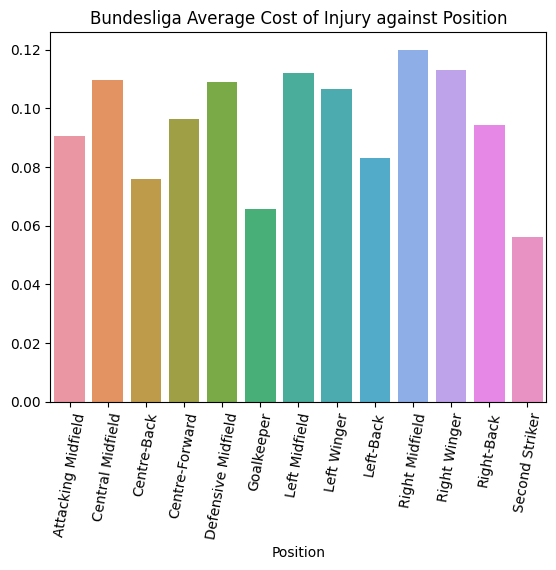

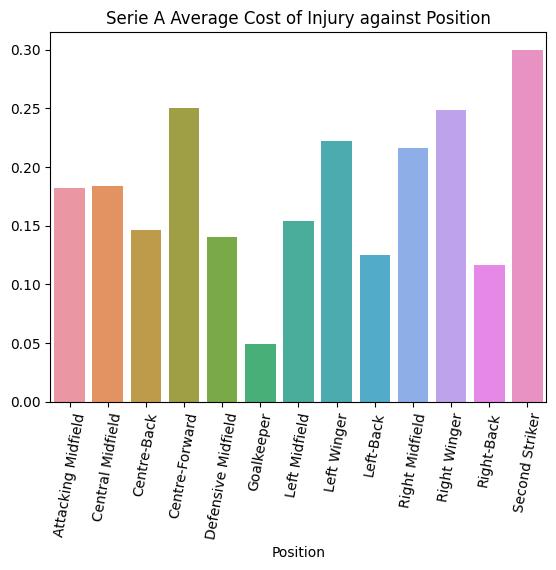

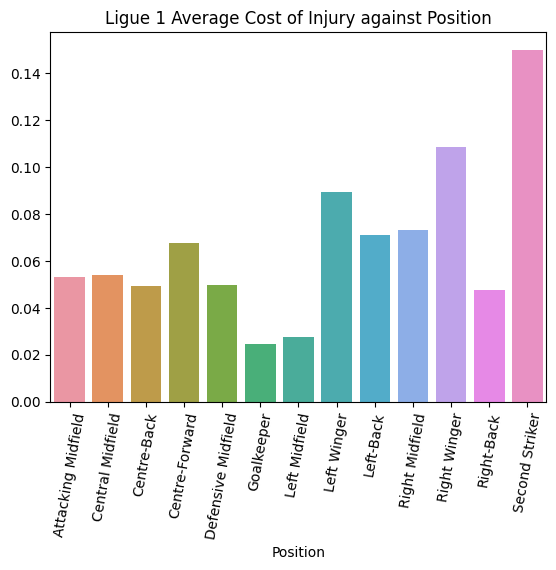

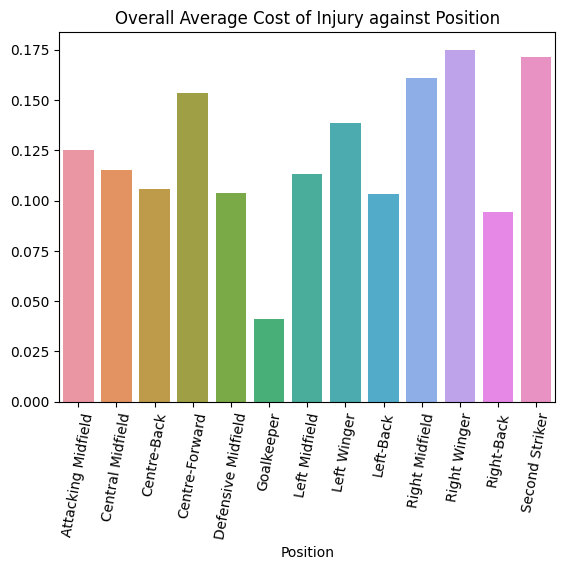

In [48]:
def get_avg_cost_pos_dist(df, title):
    avg_cost_by_pos = df.groupby('Position')['Average Injury Cost'].mean()
    sns.barplot(x=avg_cost_by_pos.index, y=avg_cost_by_pos.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_avg_cost_pos_dist(prem_player_data_df, "PL Average Cost of Injury against Position")
get_avg_cost_pos_dist(laliga_player_data_df, "La Liga Average Cost of Injury against Position")
get_avg_cost_pos_dist(bundesliga_player_data_df, "Bundesliga Average Cost of Injury against Position")
get_avg_cost_pos_dist(serie_a_player_data_df, "Serie A Average Cost of Injury against Position")
get_avg_cost_pos_dist(ligue_1_player_data_df, "Ligue 1 Average Cost of Injury against Position")
get_avg_cost_pos_dist(combined_df, "Overall Average Cost of Injury against Position")

## Average cost (in millions) of injury by position (General)

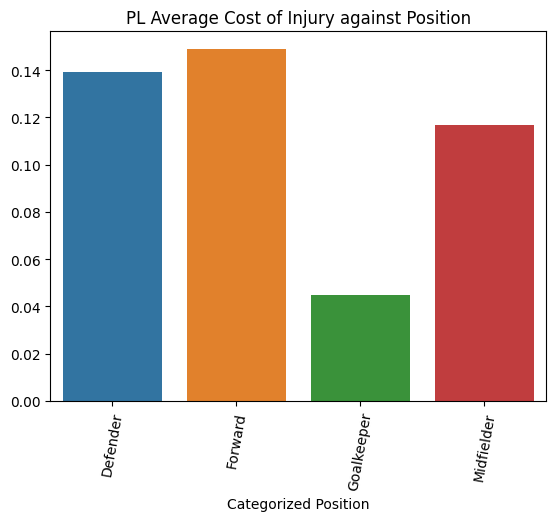

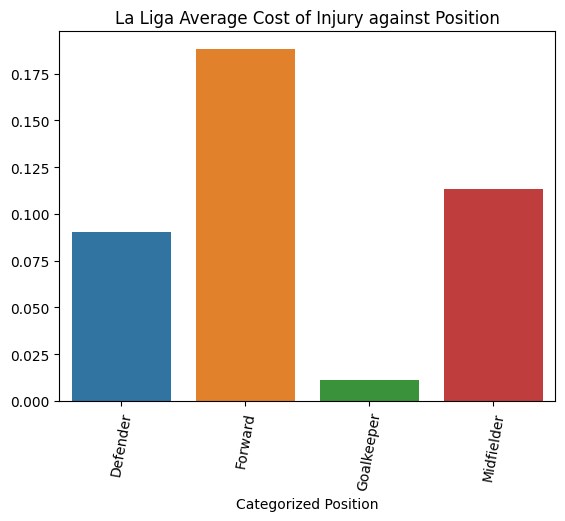

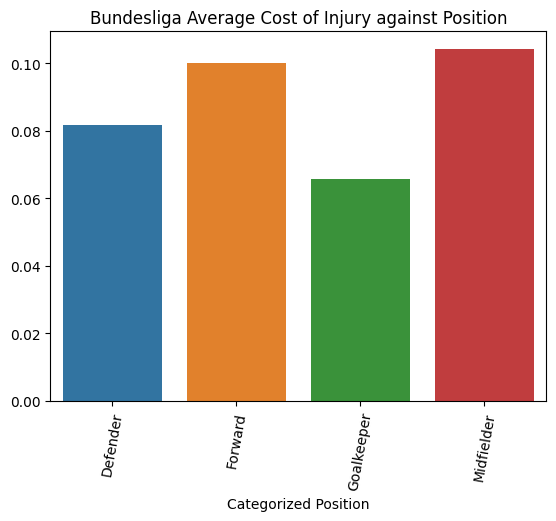

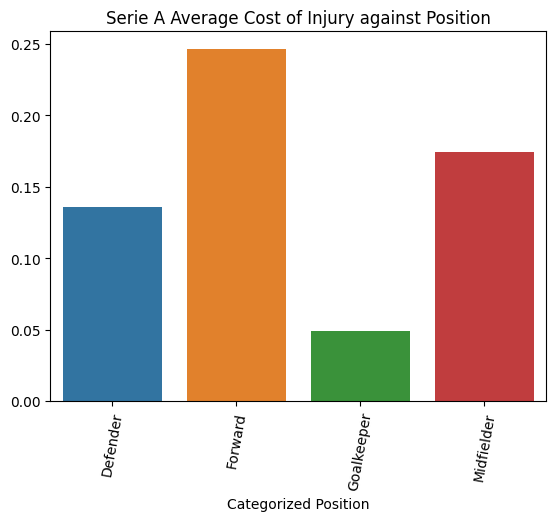

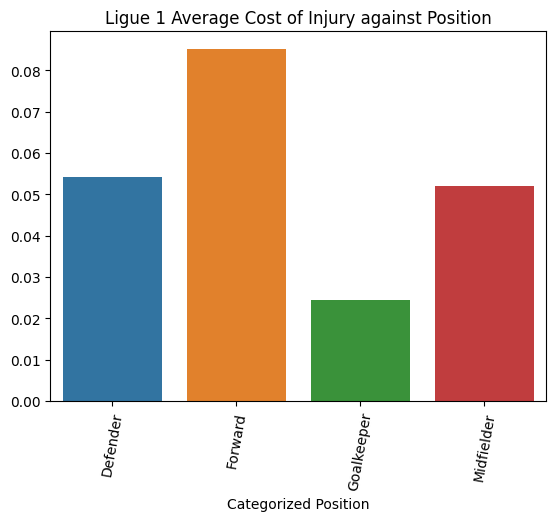

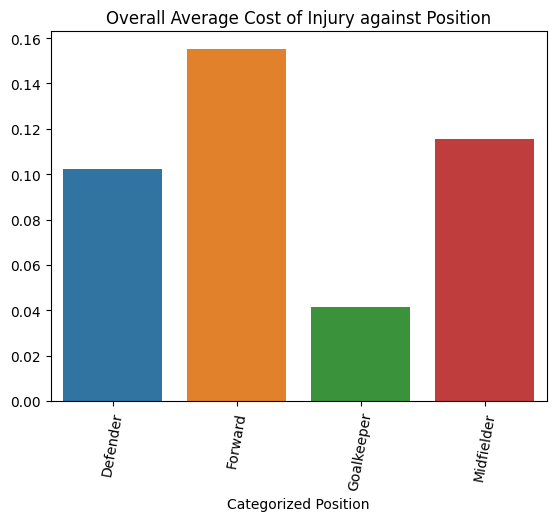

In [49]:
def get_avg_cost_cat_pos_dist(df, title):
    avg_cost_by_pos = df.groupby('Categorized Position')['Average Injury Cost'].mean()
    sns.barplot(x=avg_cost_by_pos.index, y=avg_cost_by_pos.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_avg_cost_cat_pos_dist(prem_player_data_df, "PL Average Cost of Injury against Position")
get_avg_cost_cat_pos_dist(laliga_player_data_df, "La Liga Average Cost of Injury against Position")
get_avg_cost_cat_pos_dist(bundesliga_player_data_df, "Bundesliga Average Cost of Injury against Position")
get_avg_cost_cat_pos_dist(serie_a_player_data_df, "Serie A Average Cost of Injury against Position")
get_avg_cost_cat_pos_dist(ligue_1_player_data_df, "Ligue 1 Average Cost of Injury against Position")
get_avg_cost_cat_pos_dist(combined_df, "Overall Average Cost of Injury against Position")

Other distributions:
* ~~Minutes played vs days out~~
* ~~Avg Minutes played vs positions, see if any correlation to days out vs position~~
* ~~Types of injuries and their distributions~~
* ~~Preprocess positions and find injury counts by positions~~
* ~~Average cost of each injury type for each league~~

# Tidying up Club Data
1. Standardise the names of clubs in player data and team data
2. Separate the player data into Goalkeeper and other positions for each league
3. Separate the team data into goalkeeping stats and other positions for each league
4. Add team data into player data my matching the players with their club's data

In [50]:
def find_name_diff(player_data, team_data):
    result = []
    # Easier to change 
    for name in team_data:
        if name not in player_data:
            result.append(name)
    return result

def replace_name_diff(team_data_df, name_diff_dict):
    team_data_df['Team'] = team_data_df['Team'].map(name_diff_dict).fillna(team_data_df['Team'])
    return team_data_df
        
prem_team_data_df = pd.read_csv('/kaggle/input/collected-data/Team Data/prem_team_data.csv')
prem_name_diff_dict = {
    'Manchester City': 'Man City', 
    'Newcastle Utd': 'Newcastle', 
    'Manchester Utd': 'Man Utd', 
    "Nott'ham Forest": 'Nottm Forest', 
    'Luton Town': 'Luton', 
    'Sheffield Utd': 'Sheff Utd'
}
prem_team_data_df = replace_name_diff(prem_team_data_df, prem_name_diff_dict)
prem_player_unique_clubs = prem_player_data_df['Club'].unique()
prem_team_unique_clubs = prem_team_data_df['Team'].unique()
assert(len(find_name_diff(prem_player_unique_clubs, prem_team_unique_clubs)) == 0)
assert(len(find_name_diff(prem_team_unique_clubs, prem_player_unique_clubs)) == 0)


bundesliga_team_data_df = pd.read_csv('/kaggle/input/collected-data/Team Data/bundesliga_team_data.csv')
bundesliga_name_diff_dict = {
    'Leverkusen': 'B. Leverkusen', 
    'Stuttgart': 'VfB Stuttgart', 
    'Dortmund': 'Bor. Dortmund', 
    'Eint Frankfurt': 'E. Frankfurt', 
    'Hoffenheim': 'TSG Hoffenheim', 
    'Freiburg': 'SC Freiburg', 
    'Augsburg': 'FC Augsburg', 
    'Wolfsburg': 'VfL Wolfsburg', 
    'Mainz 05': '1.FSV Mainz 05', 
    'Gladbach': "Bor. M'gladbach", 
    'Bochum': 'VfL Bochum', 
    'Köln': '1.FC Köln'
}
bundesliga_team_data_df = replace_name_diff(bundesliga_team_data_df, bundesliga_name_diff_dict)
bundesliga_player_unique_clubs = bundesliga_player_data_df['Club'].unique()
bundesliga_team_unique_clubs = bundesliga_team_data_df['Team'].unique()
assert(len(find_name_diff(bundesliga_player_unique_clubs, bundesliga_team_unique_clubs)) == 0)
assert(len(find_name_diff(bundesliga_team_unique_clubs, bundesliga_player_unique_clubs)) == 0)

laliga_team_data_df = pd.read_csv('/kaggle/input/collected-data/Team Data/laliga_team_data.csv')
laliga_name_diff_dict = {
    'Athletic Club': 'Athletic', 
    'Betis': 'Real Betis', 
    'Osasuna': 'CA Osasuna', 
    'Celta Vigo': 'Celta de Vigo', 
    'Sevilla': 'Sevilla FC', 
    'Mallorca': 'RCD Mallorca', 
    'Las Palmas': 'UD Las Palmas', 
    'Cádiz': 'Cádiz CF', 
    'Almería': 'UD Almería', 
    'Granada': 'Granada CF'
}
laliga_team_data_df = replace_name_diff(laliga_team_data_df, laliga_name_diff_dict)
laliga_player_unique_clubs = laliga_player_data_df['Club'].unique()
laliga_team_unique_clubs = laliga_team_data_df['Team'].unique()
assert(len(find_name_diff(laliga_player_unique_clubs, laliga_team_unique_clubs)) == 0)
assert(len(find_name_diff(laliga_team_unique_clubs, laliga_player_unique_clubs)) == 0)

serie_a_team_data_df = pd.read_csv('/kaggle/input/collected-data/Team Data/serie_a_team_data.csv')
serie_a_name_diff_dict = {
    'Milan': 'AC Milan', 
    'Atalanta': 'Atalanta BC', 
    'Roma': 'AS Roma', 
    'Napoli': 'SSC Napoli', 
    'Udinese': 'Udinese Calcio', 
    'Cagliari': 'Cagliari Calcio', 
    'Empoli': 'FC Empoli'
}
serie_a_team_data_df = replace_name_diff(serie_a_team_data_df, serie_a_name_diff_dict)
serie_a_player_unique_clubs = serie_a_player_data_df['Club'].unique()
serie_a_team_unique_clubs = serie_a_team_data_df['Team'].unique()
assert(len(find_name_diff(serie_a_player_unique_clubs, serie_a_team_unique_clubs)) == 0)
assert(len(find_name_diff(serie_a_team_unique_clubs, serie_a_player_unique_clubs)) == 0)

ligue_1_team_data_df = pd.read_csv('/kaggle/input/collected-data/Team Data/ligue_1_team_data.csv')
ligue_1_name_diff_dict = {
    'Paris S-G': 'Paris SG', 
    'Brest': 'Stade Brestois', 
    'Lille': 'LOSC Lille', 
    'Nice': 'OGC Nice', 
    'Lyon': 'Olympique Lyon', 
    'Reims': 'Stade Reims', 
    'Rennes': 'Stade Rennais', 
    'Strasbourg': 'R. Strasbourg', 
    'Nantes': 'FC Nantes', 
    'Le Havre': 'Le Havre AC', 
    'Metz': 'FC Metz', 
    'Lorient': 'FC Lorient'
}
ligue_1_team_data_df = replace_name_diff(ligue_1_team_data_df, ligue_1_name_diff_dict)
ligue_1_player_unique_clubs = ligue_1_player_data_df['Club'].unique()
ligue_1_team_unique_clubs = ligue_1_team_data_df['Team'].unique()
assert(len(find_name_diff(ligue_1_player_unique_clubs, ligue_1_team_unique_clubs)) == 0)
assert(len(find_name_diff(ligue_1_team_unique_clubs, ligue_1_player_unique_clubs)) == 0)

In [51]:
def add_stats(player_df, team_stats_df):
    merged_df = pd.merge(player_df, team_stats_df, left_on='Club', right_on='Team', how='left')

    # Drop the redundant 'Team' column
    merged_df = merged_df.drop('Team', axis=1)
    return merged_df

In [52]:
gk_columns = ['Team', 'Goals Against Per 90', 'Shots On Target Against', 'Saves Percentage', 'GK Passes attemped', 'GK Throws Attempted', 'GK Crosses Faced', 'Sweeper per 90']
other_columns = ['Team', 'Sweeper per 90', 'Players Tackled', 'Dribblers Tackled', 'Blocks', 'Interceptions', 'Clearances', 'Goals', 'Shots', 'Shots on Target', 'Shots per 90', 'Shots on Target per 90', 'Expected Goals', 'Passes Completed', 'Passes Attempted', 'Crosses', 'Progressive Passes', 'Shot Creating Actions', 'Shot Creating Actions per 90', 'Goal Creating Actions', 'Goal Creating Actions per 90', 'Defensive Touches', 'Attacking Touches', 'Take Ons Attempted', 'Take Ons Tackled', 'Yellow Cards', 'Red Cards', 'Fouls Committed', 'Fouls Drawn', 'Aerial Won', 'Aerial Lost']

prem_goalkeepers_df = prem_player_data_df[prem_player_data_df['Categorized Position'] == 'Goalkeeper']
prem_other_players_df = prem_player_data_df[prem_player_data_df['Categorized Position'] != 'Goalkeeper']
prem_goalkeeper_data_df = prem_team_data_df[gk_columns]
prem_other_data_df = prem_team_data_df[other_columns]
prem_goalkeepers_df = add_stats(prem_goalkeepers_df, prem_goalkeeper_data_df)
prem_other_players_df = add_stats(prem_other_players_df, prem_other_data_df)

laliga_goalkeepers_df = laliga_player_data_df[laliga_player_data_df['Categorized Position'] == 'Goalkeeper']
laliga_other_players_df = laliga_player_data_df[laliga_player_data_df['Categorized Position'] != 'Goalkeeper']
laliga_goalkeeper_data_df = laliga_team_data_df[gk_columns]
laliga_other_data_df = laliga_team_data_df[other_columns]
laliga_goalkeepers_df = add_stats(laliga_goalkeepers_df, laliga_goalkeeper_data_df)
laliga_other_players_df = add_stats(laliga_other_players_df, laliga_other_data_df)

bundesliga_goalkeepers_df = bundesliga_player_data_df[bundesliga_player_data_df['Categorized Position'] == 'Goalkeeper']
bundesliga_other_players_df = bundesliga_player_data_df[bundesliga_player_data_df['Categorized Position'] != 'Goalkeeper']
bundesliga_goalkeeper_data_df = bundesliga_team_data_df[gk_columns]
bundesliga_other_data_df = bundesliga_team_data_df[other_columns]
bundesliga_goalkeepers_df = add_stats(bundesliga_goalkeepers_df, bundesliga_goalkeeper_data_df)
bundesliga_other_players_df = add_stats(bundesliga_other_players_df, bundesliga_other_data_df)

serie_a_goalkeepers_df = serie_a_player_data_df[serie_a_player_data_df['Categorized Position'] == 'Goalkeeper']
serie_a_other_players_df = serie_a_player_data_df[serie_a_player_data_df['Categorized Position'] != 'Goalkeeper']
serie_a_goalkeeper_data_df = serie_a_team_data_df[gk_columns]
serie_a_other_data_df = serie_a_team_data_df[other_columns]
serie_a_goalkeepers_df = add_stats(serie_a_goalkeepers_df, serie_a_goalkeeper_data_df)
serie_a_other_players_df = add_stats(serie_a_other_players_df, serie_a_other_data_df)

ligue_1_goalkeepers_df = ligue_1_player_data_df[ligue_1_player_data_df['Categorized Position'] == 'Goalkeeper']
ligue_1_other_players_df = ligue_1_player_data_df[ligue_1_player_data_df['Categorized Position'] != 'Goalkeeper']
ligue_1_goalkeeper_data_df = ligue_1_team_data_df[gk_columns]
ligue_1_other_data_df = ligue_1_team_data_df[other_columns]
ligue_1_goalkeepers_df = add_stats(ligue_1_goalkeepers_df, ligue_1_goalkeeper_data_df)
ligue_1_other_players_df = add_stats(ligue_1_other_players_df, ligue_1_other_data_df)

In [53]:
# Create a list of DataFrames
all_gk_dataframes = [prem_goalkeepers_df, laliga_goalkeepers_df, bundesliga_goalkeepers_df, serie_a_goalkeepers_df, ligue_1_goalkeepers_df]
all_other_dataframes = [prem_other_players_df, laliga_other_players_df, bundesliga_other_players_df, serie_a_other_players_df, ligue_1_other_players_df]

# Concatenate the DataFrames vertically
combined_goalkeeper_df = pd.concat(all_gk_dataframes, ignore_index=True)
combined_goalkeeper_df.to_csv('combined_goalkeeper_data.csv', index=False)  
combined_other_position_df = pd.concat(all_other_dataframes, ignore_index=True)
combined_other_position_df.to_csv('combined_other_position_data.csv', index=False)  

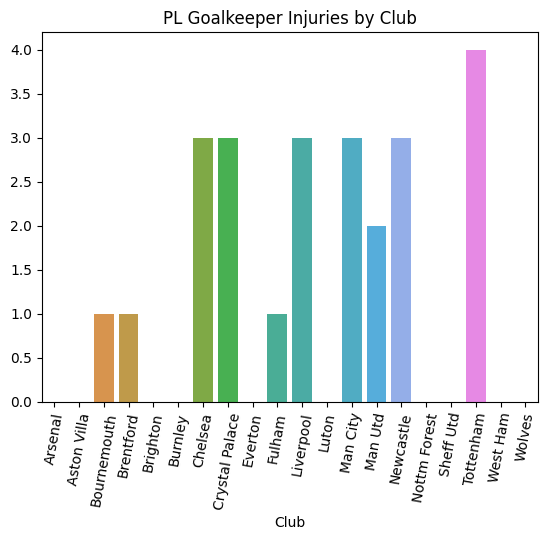

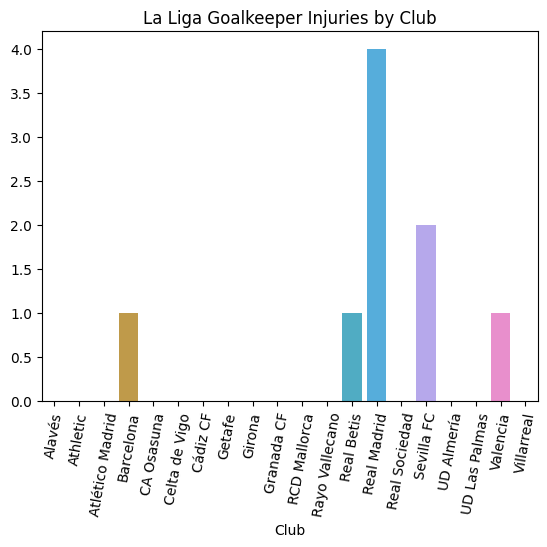

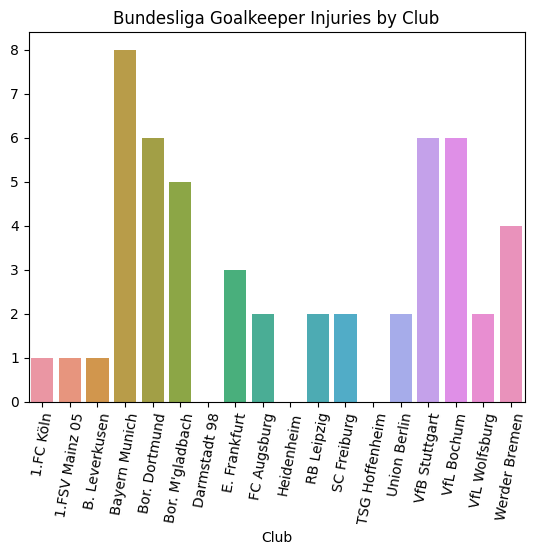

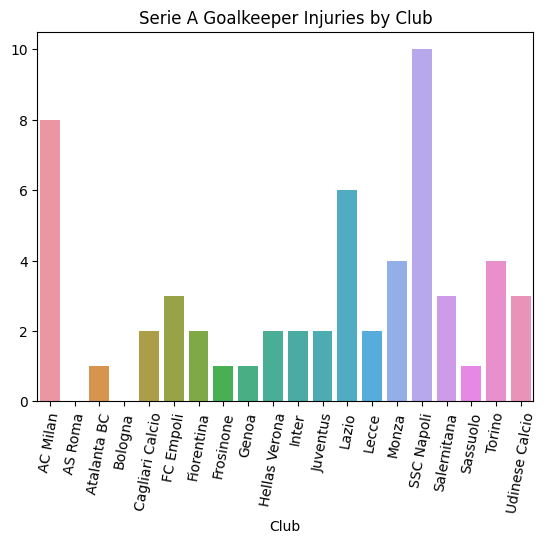

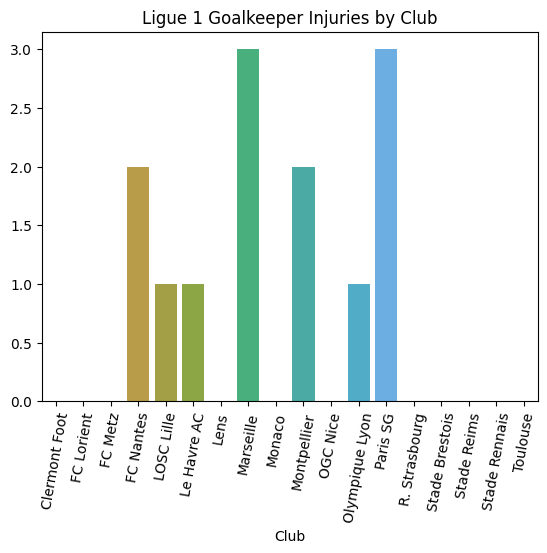

In [54]:
def get_club_injuries_dist(df, title):
    injuries_by_club = df.groupby('Club')['Injury Count'].sum()
    sns.barplot(x=injuries_by_club.index, y=injuries_by_club.values, errorbar="sd").set(title=title)
    plt.xticks(rotation=80)
    plt.show()
    
get_club_injuries_dist(prem_goalkeepers_df, "PL Goalkeeper Injuries by Club")
get_club_injuries_dist(laliga_goalkeepers_df, "La Liga Goalkeeper Injuries by Club")
get_club_injuries_dist(bundesliga_goalkeepers_df, "Bundesliga Goalkeeper Injuries by Club")
get_club_injuries_dist(serie_a_goalkeepers_df, "Serie A Goalkeeper Injuries by Club")
get_club_injuries_dist(ligue_1_goalkeepers_df, "Ligue 1 Goalkeeper Injuries by Club")

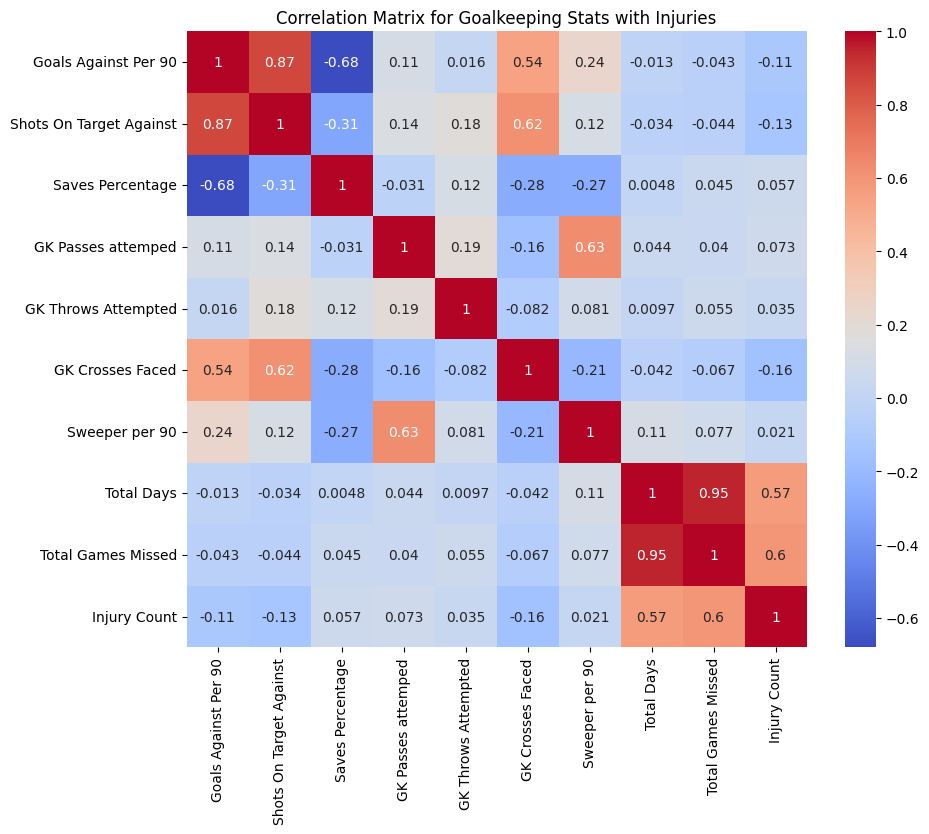

In [55]:
# Select desired columns for correlation
columns_to_correlate = ['Goals Against Per 90', 'Shots On Target Against', 'Saves Percentage', 'GK Passes attemped', 'GK Throws Attempted', 'GK Crosses Faced', 'Sweeper per 90', 'Total Days', 'Total Games Missed', 'Injury Count']  # Replace with your desired columns

# Calculate correlation matrix for selected columns
correlation_matrix = combined_goalkeeper_df[columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Goalkeeping Stats with Injuries')
plt.show()

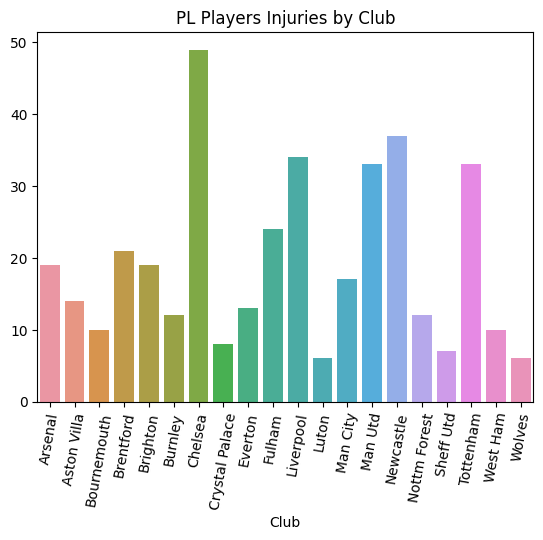

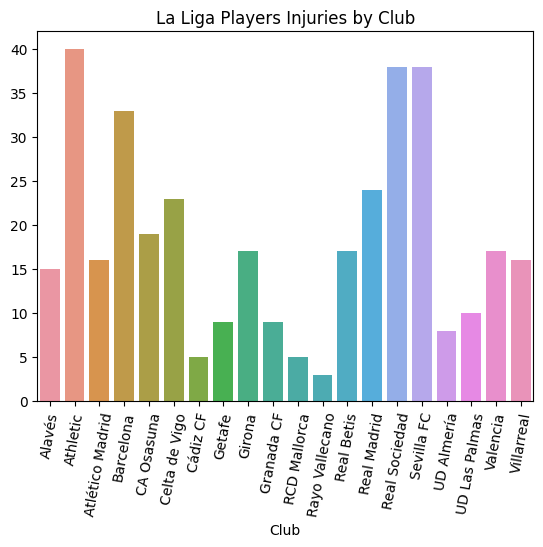

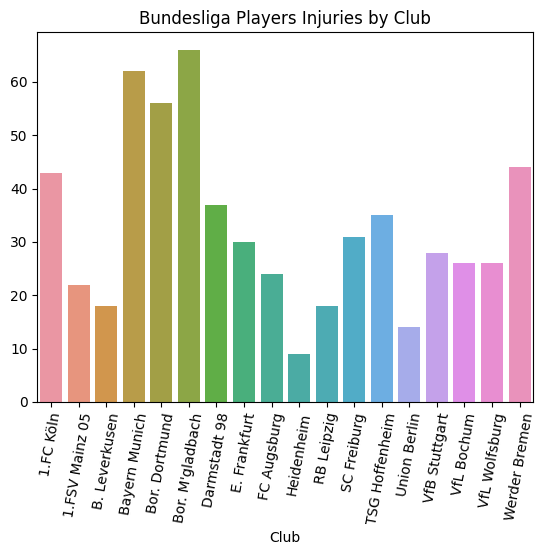

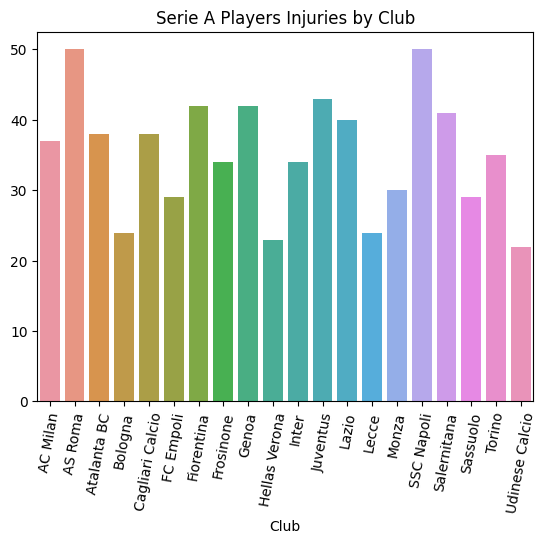

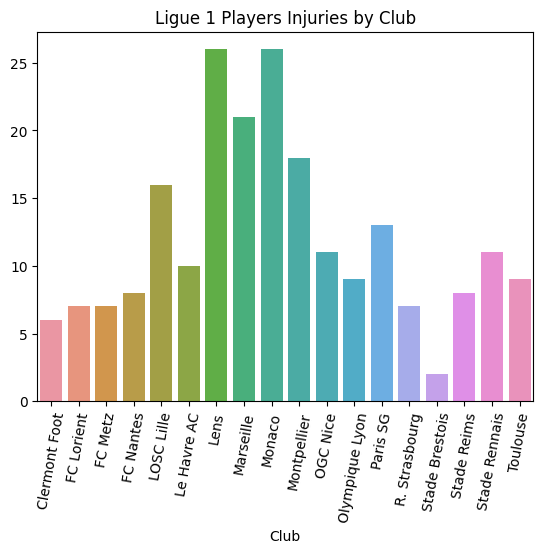

In [56]:
get_club_injuries_dist(prem_other_players_df, "PL Players Injuries by Club")
get_club_injuries_dist(laliga_other_players_df, "La Liga Players Injuries by Club")
get_club_injuries_dist(bundesliga_other_players_df, "Bundesliga Players Injuries by Club")
get_club_injuries_dist(serie_a_other_players_df, "Serie A Players Injuries by Club")
get_club_injuries_dist(ligue_1_other_players_df, "Ligue 1 Players Injuries by Club")

In [60]:
# Select desired columns for correlation
def_columns_to_correlate = ["Players Tackled", "Dribblers Tackled", "Blocks", "Interceptions", "Clearances", 'Total Days', 'Total Games Missed', 'Injury Count']
shooting_columns_to_correlate = ["Goals", "Shots", "Shots on Target", "Shots per 90", "Shots on Target per 90", "Expected Goals", 'Total Days', 'Total Games Missed', 'Injury Count']
passing_columns_to_correlate = ["Passes Completed", "Passes Attempted", "Crosses", "Progressive Passes", 'Total Days', 'Total Games Missed', 'Injury Count']
goal_and_shot_creation_columns_to_correlate = ["Shot Creating Actions", "Shot Creating Actions per 90", "Goal Creating Actions", "Goal Creating Actions per 90", 'Total Days', 'Total Games Missed', 'Injury Count']
possession_columns_to_correlate = ["Defensive Touches", "Attacking Touches", "Take Ons Attempted", "Take Ons Tackled", 'Total Days', 'Total Games Missed', 'Injury Count']
misc_columns_to_correlate = ["Yellow Cards", "Red Cards", "Fouls Committed", "Fouls Drawn", "Aerial Won", "Aerial Lost", 'Total Days', 'Total Games Missed', 'Injury Count']

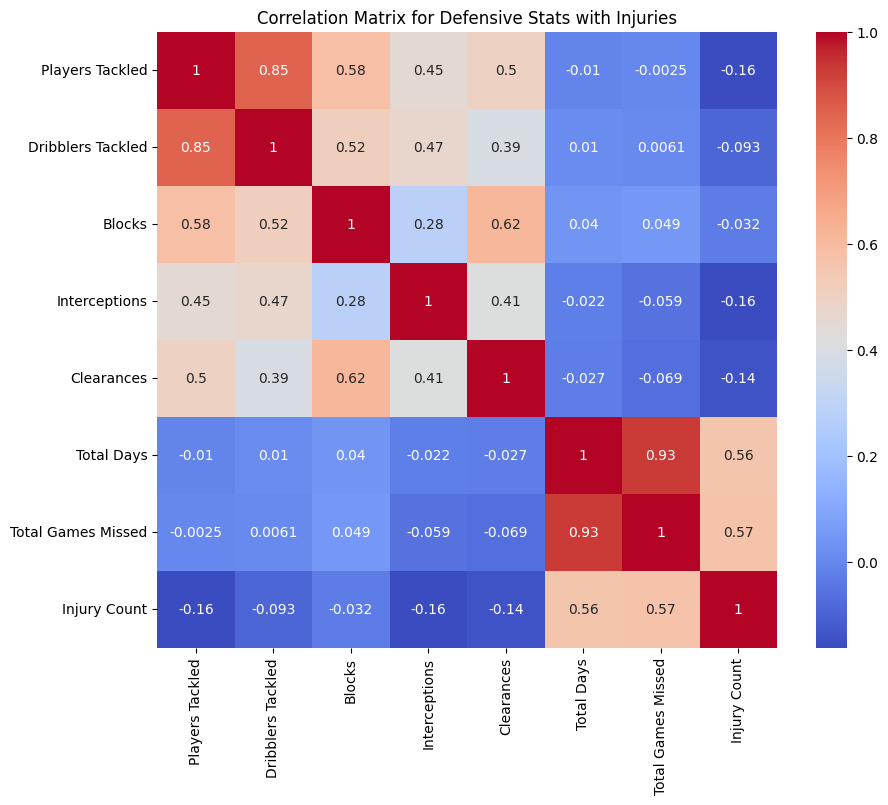

In [63]:
# Calculate correlation matrix for selected columns
correlation_matrix = combined_other_position_df[def_columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Defensive Stats with Injuries')
plt.show()

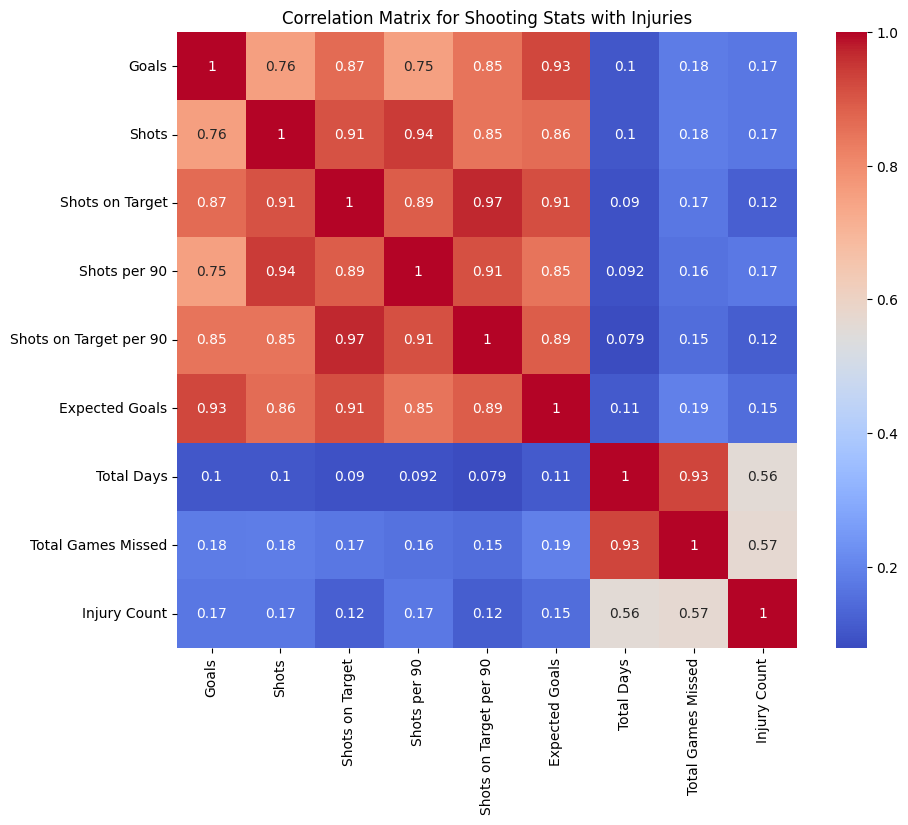

In [64]:
# Calculate correlation matrix for selected columns
correlation_matrix = combined_other_position_df[shooting_columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Shooting Stats with Injuries')
plt.show()

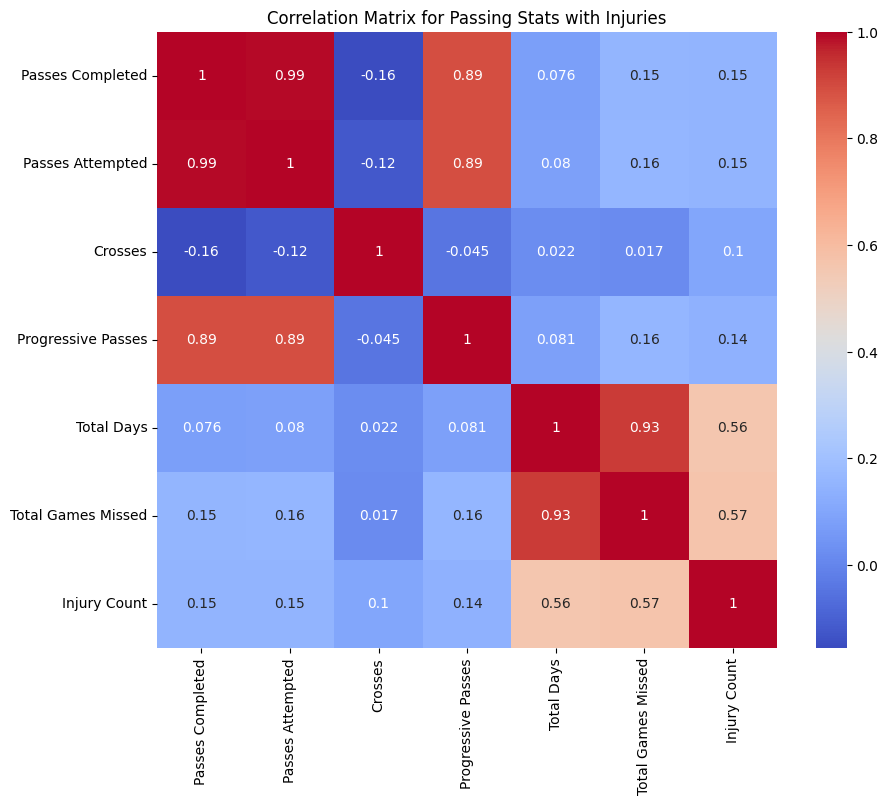

In [65]:
# Calculate correlation matrix for selected columns
correlation_matrix = combined_other_position_df[passing_columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Passing Stats with Injuries')
plt.show()

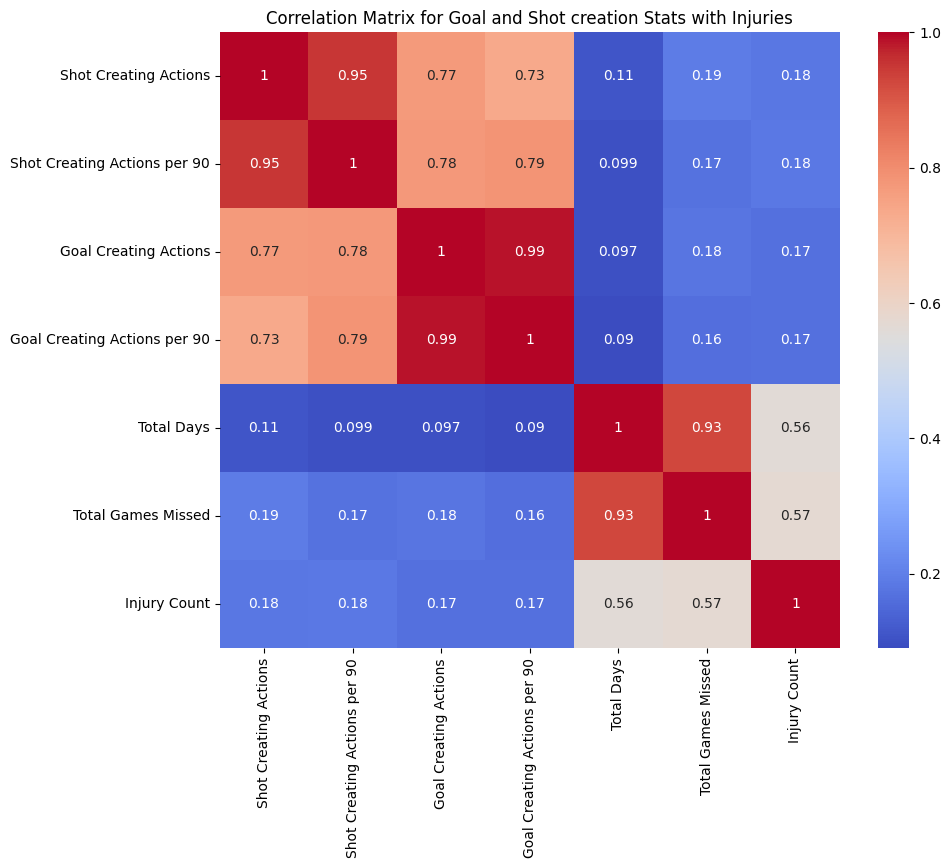

In [66]:
# Calculate correlation matrix for selected columns
correlation_matrix = combined_other_position_df[goal_and_shot_creation_columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Goal and Shot creation Stats with Injuries')
plt.show()

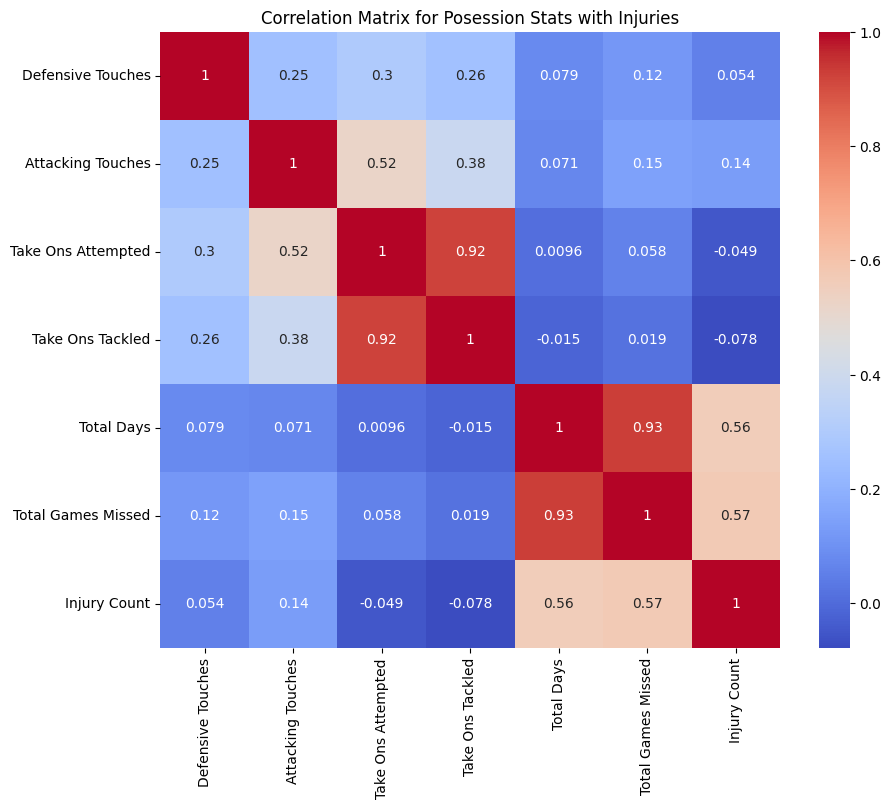

In [67]:
# Calculate correlation matrix for selected columns
correlation_matrix = combined_other_position_df[possession_columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Posession Stats with Injuries')
plt.show()

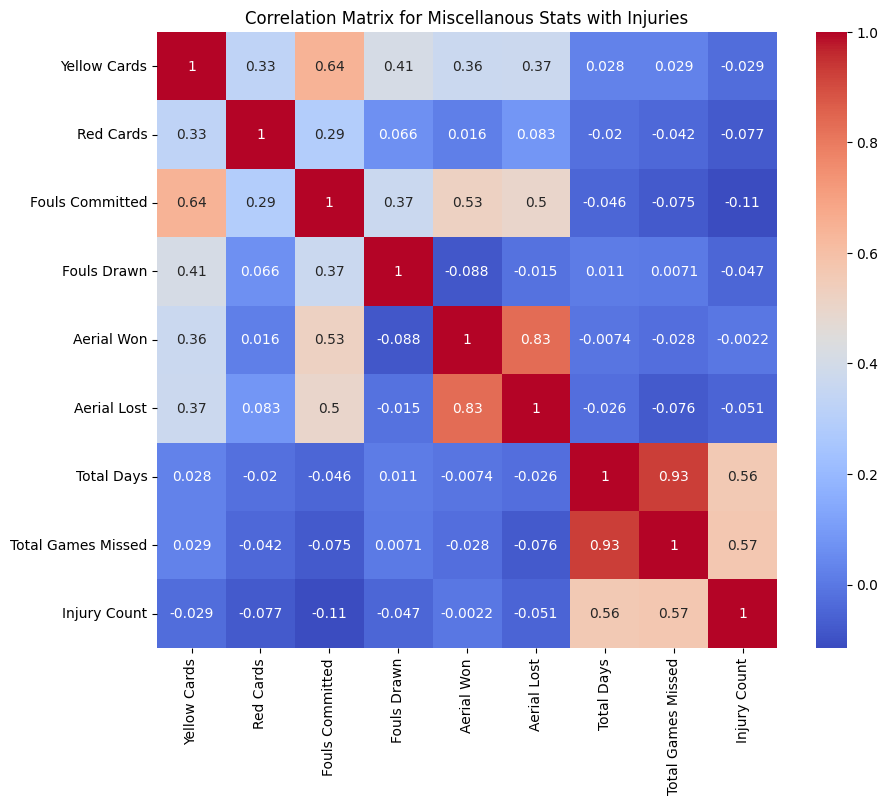

In [68]:
# Calculate correlation matrix for selected columns
correlation_matrix = combined_other_position_df[misc_columns_to_correlate].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Miscellanous Stats with Injuries')
plt.show()

Merge with **club data**
1. Sort by positions (only need to separate gk from other positions)
2. Map clubs to player
3. Insert statistics for each player (players from same clubs will have same avg stats)
4. Distribution of injuries per club (days out and injury types)
5. Create a correlation matrix between club-level injury metrics (e.g., total injuries, total days lost) and playing style metrics (e.g., tackles, passes, aerial duels).
    * Correlation between Tackles and Muscle Injuries: Calculate the correlation between the number of tackles per game for a club and the number of muscle injuries. A high positive correlation might suggest a link between high-intensity defensive actions and muscle strain injuries.
    * Comparison of Playing Styles: Compare the playing styles of clubs with high and low injury rates to identify potential differences in factors like aerial duels, possession-based play, or defensive intensity.


Data Preprocessing with Refereeing Data
1. Use the distribution of injuries like with club data
2. Identify clubs that consistently experience more or fewer fouls, cards, etc.
3. Correlation Analysis:
    * Calculate correlation coefficients between club-level injury rates and refereeing metrics (e.g., fouls per game, tackles per game).
    * Identify potential relationships between aggressive playing styles (indicated by high tackle counts, foul counts) and injury rates.